dataset, https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008    
data documentation: https://github.com/uci-ml-repo/ucimlrepo  

Treatment:    T = 1 if A1C test done, 0 otherwise  
Outcome:      Y = 0 if readmitted <30 days, 0 otherwise  
Confounders:  variables occurring prior to treatment that predict treatment and/or outcome  

Initial treatment model: logistic regression  

ChatGPT, https://chatgpt.com/share/68fdac4d-22b8-8009-bab9-01ab8318dc2b  


Questions:
Treatment and outcomes are both imbalanced. Is this a concern? (Especially the imbalanced outcomes?)  
Do I need to assess the positivity assumption?  

steps for initial causal models?, https://chatgpt.com/share/68feef2c-983c-8009-a2ea-bd3b5e36e10b  

Medium series, https://medium.com/@xwang222/causal-inference-101-ep01-why-do-we-care-7ad638ad3e4d  

In [1]:
# Import stuff
import os
import numpy as np
import pandas as pd
import zipfile
import io
import requests

# Print the current working directory
print("Current working directory:", os.getcwd())

# Download and decompress the zip file at https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip

url = "https://archive.ics.uci.edu/static/public/296/diabetes+130-us+hospitals+for+years+1999-2008.zip"

data_dir = "data/"
# Define the internal directory name for the extracted files
# dataset_name = "diabetes_dataset"

# If needed, create the data directory
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Print the full path to the data directory
print("Data directory path:", os.path.abspath(data_dir ))

r = requests.get(url) # download the zip file
z = zipfile.ZipFile(io.BytesIO(r.content)) # read the zip file
# Use dataset_name for the target folder inside data_dir
z.extractall(os.path.join(data_dir)) # extract all contents to the data directory 

# Load the datasets into pandas dataframes, without assuming any NA values
diabetic_data = pd.read_csv(
    filepath_or_buffer=os.path.join(data_dir, "diabetic_data.csv"), 
    na_filter=False
)

# IDS mapping does not have column names. Load the IDS mapping file, so that data starts from row 0
ids_mapping = pd.read_csv(
    # FIXED: Use os.path.join(data_dir, dataset_name, "IDS_mapping.csv")
    filepath_or_buffer=os.path.join(data_dir, "IDS_mapping.csv"), 
    header=None, 
    na_filter=False
)

# Display the dimensions of the dataframes
print("Diabetic Data shape:", diabetic_data.shape)
print("IDs Mapping shape:", ids_mapping.shape)

# Assert that the number of rows in diabetic_data is 101766
assert diabetic_data.shape[0] == 101766, "Diabetic data does not have 101,766 rows"

# From the paper: 
# (1) It is an inpatient encounter (a hospital admission).
# (2) It is a “diabetic” encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
# (3) The length of stay was at least 1 day and at most 14 days.
# (4) Laboratory tests were performed during the encounter.
# (5) Medications were administered during the encounter.

# From the paper: "101,766 encounters were identified to fulfill all of the above five inclusion criteria"

Current working directory: /home/tc_unix/projects/causal_inference_project
Data directory path: /home/tc_unix/projects/causal_inference_project/data
Diabetic Data shape: (101766, 50)
IDs Mapping shape: (68, 2)


In [2]:
# Adjust display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Add column names to ids_mapping
ids_mapping.columns = ["id", "description"]

# Identify and print rows where description has leading or trailing whitespace
whitespace_rows = ids_mapping[ids_mapping["description"].str.strip() != ids_mapping["description"]]
print("Rows with leading or trailing whitespace in 'description':")
print(whitespace_rows)
print("\n")

# Strip leading and trailing whitespace from "description" column
ids_mapping["description"] = ids_mapping["description"].str.strip()

# Identify and print rows where description has leading or trailing whitespace
whitespace_rows = ids_mapping[ids_mapping["description"].str.strip() != ids_mapping["description"]]
print("After stripping, rows with leading or trailing whitespace in 'description':")
print(whitespace_rows)
print("\n")

# Describe ids_mapping
print("IDs Mapping description:")
print(ids_mapping.describe(include='all'))
print("\n")

# Print ids_mapping
print(ids_mapping)
print("\n")

# Convert "id" column to integer, forcing errors to NaN
ids_mapping["id"] = pd.to_numeric(ids_mapping["id"], errors='coerce')

# Describe ids_mapping after conversion
print("IDs Mapping description after converting 'id' to numeric:")
print(ids_mapping.describe(include='all'))
print("\n")

# Create seperate dataframes for each variable that is mapped in ids_mapping

# map_admission_type_id is in rows 1:8 inclusive
map_admission_type_id  = ids_mapping.iloc[1:10, :]
# Remove rows where "description" is empty
map_admission_type_id = map_admission_type_id[map_admission_type_id["description"] != ""]
print("Admission Type ID Mapping:")
print(map_admission_type_id.to_string(index=False))
print("\n")

# discharge_disposition_id is in rows 11:41 inclusive
map_discharge_disposition_id = ids_mapping.iloc[11:42, :] 
# Remove rows where "description" is empty
map_discharge_disposition_id = map_discharge_disposition_id[map_discharge_disposition_id["description"] != ""]
print("Discharge Disposition ID Mapping:")
print(map_discharge_disposition_id.to_string(index=False))
print("\n")

# admission_source_id is in rows 43 onwards inclusive
map_admission_source_id  = ids_mapping.iloc[43:, :]
# Remove rows where "description" is empty
map_admission_source_id = map_admission_source_id[map_admission_source_id["description"] != ""]
print("Admission Source ID Mapping:")
print(map_admission_source_id.to_string(index=False))
print("\n")

Rows with leading or trailing whitespace in 'description':
    id                                        description
43   1                                 Physician Referral
47   5     Transfer from a Skilled Nursing Facility (SNF)
48   6         Transfer from another health care facility
49   7                                     Emergency Room
50   8                              Court/Law Enforcement
51   9                                      Not Available
52  10              Transfer from critial access hospital
54  12                                 Premature Delivery
55  13                                          Sick Baby
56  14                                   Extramural Birth
59  18           Transfer From Another Home Health Agency
61  20                                         Not Mapped
63  22   Transfer from hospital inpt/same fac reslt in...
64  23                          Born inside this hospital
65  24                         Born outside this hospital
66  25       

In [3]:
# Convert "codes" and "ids" to understandable descriptions using the mapping dataframes
id_columns = ["admission_type_id", "discharge_disposition_id", "admission_source_id"]

# Print the data types of the "id" columns in diabetic_data (admission_type_id, discharge_disposition_id, admission_source_id)
print("Data types of ID columns in diabetic_data:")
print(diabetic_data[id_columns].dtypes)
print("\n")

# Describe the "id" columns in diabetic_data
print("ID descriptions:")
print(diabetic_data[id_columns].describe())
print("\n")

# Create a function that uses mapping dataframe to create description column in diabetic_data
def create_description_column(data, map_df, id_col, description_col):
    # Print the type of the "id" column
    print(type(map_df["id"]))

    # Replace empty strings with None using .loc
    map_df.loc[:, "id"] = map_df.loc[:, "id"].replace('', None)
    map_df.loc[:, "description"] = map_df.loc[:, "description"].replace('', None)

    # Convert column "id" to nullable integer type
    map_df.loc[:, "id"] = map_df.loc[:, "id"].astype('Int64')

    # Create dictionary for mapping
    mapping_dict = dict(zip(map_df["id"], map_df["description"]))

    # Use .loc to add new column to data
    data.loc[:, description_col] = data[id_col].map(mapping_dict)

    # Print counts of each unique value
    print(data[description_col].value_counts(dropna=False))
    print("\n")

# Use the function to create description columns
for id_col, map_df, description_col in [
    ("admission_type_id", map_admission_type_id, "admission_type_description"),
    ("discharge_disposition_id", map_discharge_disposition_id, "discharge_disposition_description"),
    ("admission_source_id", map_admission_source_id, "admission_source_description"),
]:
    create_description_column(diabetic_data, map_df, id_col, description_col)

# Remove the "id" columns from diabetic_data, because we will use the description columns instead
diabetic_data.drop(columns=id_columns, inplace=True)

Data types of ID columns in diabetic_data:
admission_type_id           int64
discharge_disposition_id    int64
admission_source_id         int64
dtype: object


ID descriptions:
       admission_type_id  discharge_disposition_id  admission_source_id
count      101766.000000             101766.000000        101766.000000
mean            2.024006                  3.715642             5.754437
std             1.445403                  5.280166             4.064081
min             1.000000                  1.000000             1.000000
25%             1.000000                  1.000000             1.000000
50%             1.000000                  1.000000             7.000000
75%             3.000000                  4.000000             7.000000
max             8.000000                 28.000000            25.000000


<class 'pandas.core.series.Series'>
admission_type_description
Emergency        53990
Elective         18869
Urgent           18480
NULL              5291
Not Available    

In [4]:
# Print the first 2 rows of diabetic_data transposed for better readability
print("First 2 rows of Diabetic Data:")
print(diabetic_data.head(2).T)

First 2 rows of Diabetic Data:
                                                          0  \
encounter_id                                        2278392   
patient_nbr                                         8222157   
race                                              Caucasian   
gender                                               Female   
age                                                  [0-10)   
weight                                                    ?   
time_in_hospital                                          1   
payer_code                                                ?   
medical_specialty                  Pediatrics-Endocrinology   
num_lab_procedures                                       41   
num_procedures                                            0   
num_medications                                           1   
number_outpatient                                         0   
number_emergency                                          0   
number_inpatient        

In [5]:
# Print the column names of diabetic_data
print("Diabetic Data columns:", diabetic_data.columns.tolist())
print("\n")


# Describe the diabetic_data dataframe
print("Diabetic Data description:")
print(diabetic_data.describe(include='all'))
print("\n")

Diabetic Data columns: ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted', 'admission_type_description', 'discharge_disposition_description', 'admission_source_description']


Diabetic Data description:
        encounter_id   patient_nbr       race  gender      age  weight  \
count   1.017660e+05  1.01766

### Potential confounders (all are prior to A1C test decision)
CATEGORICAL:  
* race  
* gender  
* age  
* weight  
* admission_type_id  
* admission_source_id  
* payer_code  
* medical_specialty  

CONTINUOUS:
* number_outpatient  
* number_emergency  
* number_inpatient   

In [6]:
# From the paper: "we considered only the first encounter for each patient" 

# Print the data type of encounter_id
print("Data type of encounter_id:", diabetic_data['encounter_id'].dtype)

# Print the data type of patient_nbr
print("Data type of patient_nbr:", diabetic_data['patient_nbr'].dtype)

# Print the number of NA values in encounter_id and patient_nbr
print("Number of NA values in encounter_id:", diabetic_data['encounter_id'].isna().sum())
print("Number of NA values in patient_nbr:", diabetic_data['patient_nbr'].isna().sum())

# Create a column that for each patient_nbr, identifues the ordinal rank of each encounter_id
encounter_rank = diabetic_data.groupby('patient_nbr')['encounter_id'].rank(method='first')

# Print the number of unique patient_nbr values
print(f"Number of unique patient_nbr values: {diabetic_data['patient_nbr'].nunique()}")

# Identify the number of unique patient_nbr values where encounter_rank > 1
num_multiple_encounters = diabetic_data[encounter_rank > 1]['patient_nbr'].nunique()
print(f"Number of patients with multiple encounters: {num_multiple_encounters}\n")

Data type of encounter_id: int64
Data type of patient_nbr: int64
Number of NA values in encounter_id: 0
Number of NA values in patient_nbr: 0
Number of unique patient_nbr values: 71518
Number of patients with multiple encounters: 16773



In [7]:
# From the paper: "we removed all encounters that resulted in either discharge to a hospice or patient death"

# Identify rows where "discharge_disposition_description" contains 'hospice', 'expired', or 'death'
hospice_death_mask = diabetic_data['discharge_disposition_description'].str.contains(
    'hospice|expired|death', case=False, na=False
)

# Count of rows identified
num_hospice_death = hospice_death_mask.sum()
print(f"Number of hospice/death discharges: {num_hospice_death}\n")

# Unique discharge descriptions and their counts
hospice_death_descriptions = diabetic_data.loc[
    hospice_death_mask, 'discharge_disposition_description'
].value_counts()

print("Counts by unique discharge disposition (hospice/death):")
print(hospice_death_descriptions)

# Drop these rows from diabetic_data_unique
#diabetic_data_unique = diabetic_data_unique[~hospice_death_mask]

# Print the shape of the cleaned dataframe
#print("Shape of diabetic_data_unique after removing hospice/death discharges:", diabetic_data_unique.shape)

# From the paper: "After performing the above-described operations, we were left with 69,984 encounters"

# Drop rows where "encounter_rank" > 1 or "hospice_death_mask" == True
diabetic_data_unique = diabetic_data[(encounter_rank == 1) & (~hospice_death_mask)].copy()

# Print the shape of the cleaned dataframe
print("Shape of diabetic_data_unique after filtering to first encounters and removing hospice/death discharges:", diabetic_data_unique.shape)

Number of hospice/death discharges: 2423

Counts by unique discharge disposition (hospice/death):
discharge_disposition_description
Expired                                                   1642
Hospice / home                                             399
Hospice / medical facility                                 372
Expired at home. Medicaid only, hospice.                     8
Expired in a medical facility. Medicaid only, hospice.       2
Name: count, dtype: int64
Shape of diabetic_data_unique after filtering to first encounters and removing hospice/death discharges: (69973, 50)


In [8]:
# From the paper: "(2) It is a “diabetic” encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis"
# Ensure "diabetes was entered to the system as adiagnosis"
# “Diagnosis” stands for a primary diagnosis with possible values: ... “diabetes” for icd9: 250.xx

# Create a variable to hold True or False indicating if a diagnosis is diabetes
# This checks does not work and fails to find the ~69K records the paper mentions.
# This might be because diabetes is in diagnoeses beyond diag_3

# Safe helper: check if code starts with "250", works even with NaN
def starts_with_250(series):
    return series.fillna("").astype(str).str.startswith("250")

# Create diabetes indicator
diabetic_data_unique["is_diabetes_diagnosis"] = (
      starts_with_250(diabetic_data_unique["diag_1"])
    | starts_with_250(diabetic_data_unique["diag_2"])
    | starts_with_250(diabetic_data_unique["diag_3"])
    | (diabetic_data_unique["diabetesMed"] == "Yes")
)

# Print the counts of diabetes diagnosis
diabetes_diagnosis_counts = diabetic_data_unique['is_diabetes_diagnosis'].value_counts(dropna=False)
print("Diabetes Diagnosis Counts:")
print(diabetes_diagnosis_counts)
print("\n")

Diabetes Diagnosis Counts:
is_diabetes_diagnosis
True     58896
False    11077
Name: count, dtype: int64




In [9]:
# From the paper: "# (3) The length of stay was at least 1 day and at most 14 days."
# Ensure length of stay is >= 1
print("Length of Stay description:")
print(diabetic_data['time_in_hospital'].describe())
print("\n")

# From the paper: "(5) Medications were administered during the encounter."
# Ensure num_medications  is >= 1
print("Number of Medications description:")
print(diabetic_data['num_medications'].describe())

Length of Stay description:
count    101766.000000
mean          4.395987
std           2.985108
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          14.000000
Name: time_in_hospital, dtype: float64


Number of Medications description:
count    101766.000000
mean         16.021844
std           8.127566
min           1.000000
25%          10.000000
50%          15.000000
75%          20.000000
max          81.000000
Name: num_medications, dtype: float64


In [10]:
# Describe the cleaned diabetic_data_unique dataframe
print("Cleaned Diabetic Data description:")
print(diabetic_data_unique.describe(include='all'))
print("\n")

Cleaned Diabetic Data description:
        encounter_id   patient_nbr       race  gender      age weight  \
count   6.997300e+04  6.997300e+04      69973   69973    69973  69973   
unique           NaN           NaN          6       3       10     10   
top              NaN           NaN  Caucasian  Female  [70-80)      ?   
freq             NaN           NaN      52292   37229    17750  67185   
mean    1.566286e+08  5.493770e+07        NaN     NaN      NaN    NaN   
std     1.003493e+08  3.948019e+07        NaN     NaN      NaN    NaN   
min     1.252200e+04  1.350000e+02        NaN     NaN      NaN    NaN   
25%     8.129994e+07  2.334182e+07        NaN     NaN      NaN    NaN   
50%     1.438572e+08  4.797652e+07        NaN     NaN      NaN    NaN   
75%     2.153448e+08  8.749500e+07        NaN     NaN      NaN    NaN   
max     4.438672e+08  1.895026e+08        NaN     NaN      NaN    NaN   

        time_in_hospital payer_code medical_specialty  num_lab_procedures  \
count      

### Compute predictors used in the paper, as shown in Table 4 (page 7 of the paper)

In [11]:
# discharge (home, other)
# Print count of the unique values in discharge_disposition_description
print("Discharge Disposition Description Counts:")
print(diabetic_data_unique['discharge_disposition_description'].value_counts(dropna=False))
print("\n")

def coarsen_discharge_disposition(description):
    if "home" in description.lower():
        return "home"
    else:
        return "other"

diabetic_data_unique['discharge_p'] = diabetic_data_unique['discharge_disposition_description'].apply(coarsen_discharge_disposition)
print("discharge_p counts:")
print(diabetic_data_unique['discharge_p'].value_counts(dropna=False))

Discharge Disposition Description Counts:
discharge_disposition_description
Discharged to home                                                                                           44317
Discharged/transferred to SNF                                                                                 8784
Discharged/transferred to home with home health service                                                       8289
NULL                                                                                                          2474
Discharged/transferred to another short term hospital                                                         1539
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1410
Discharged/transferred to another type of inpatient care institution                                           913
Not Mapped                                                                                                     778
Disc

In [12]:
# race_p (African American, Caucasian, Missing, Other) [check below]
# race

# Print the count of each unique value of "race"
print(diabetic_data_unique["race"].value_counts(dropna=False))
print("\n")

# Create coarse mapping for race
race_coarse_mapping = {
    'AfricanAmerican': 'AfricanAmerican',
    'Caucasian': 'Caucasian',
    'Hispanic': 'Other',
    'Asian': 'Other',
    '?': 'Missing',
    'Other': 'Other',
    'Unknown': 'Other'
}

diabetic_data_unique['race_p'] = (
    diabetic_data_unique['race'].map(race_coarse_mapping)
)

# Print the count of each unique value of the new "coarse" column, including NA's, sorted
print("Counts of race_p:")
print(diabetic_data_unique['race_p'].value_counts(dropna=False).sort_index())
print("\n")

# Create coarse mapping for race
race_coarse_mapping_tc = {
    'AfricanAmerican': 'AfricanAmerican',
    'Caucasian': 'Caucasian',
    'Hispanic': 'Hispanic',
    'Asian': 'Asian',
    '?': 'Other/Missing',
    'Other': 'Other/Missing',
    'Unknown': 'Other/Missing'
}

diabetic_data_unique['race_tc'] = (
    diabetic_data_unique['race'].map(race_coarse_mapping_tc)
)

# Print the count of each unique value of the new "coarse" column, including NA's, sorted
print("Counts of race_tc:")
print(diabetic_data_unique['race_tc'].value_counts(dropna=False).sort_index())


race
Caucasian          52292
AfricanAmerican    12625
?                   1918
Hispanic            1500
Other               1150
Asian                488
Name: count, dtype: int64


Counts of race_p:
race_p
AfricanAmerican    12625
Caucasian          52292
Missing             1918
Other               3138
Name: count, dtype: int64


Counts of race_tc:
race_tc
AfricanAmerican    12625
Asian                488
Caucasian          52292
Hispanic            1500
Other/Missing       3068
Name: count, dtype: int64


In [13]:
# admission_source_p (Emrgency, Other, Referral)

# Print the counts of each admission_source_description
print("Counts of admission_source_description:")
print(diabetic_data_unique["admission_source_description"].value_counts(dropna=False))
print("\n")

# Create coarse mapping for admission_source_description
def coarsen_admission_source(desc):
    if desc == "Emergency Room":
        return "Emergency Room"
    elif desc in ["Physician Referral", "Clinic Referral"]:
        return "Physician or Clinic Referral"
    else:
        return "Other"

diabetic_data_unique["admission_source_p"] = diabetic_data_unique["admission_source_description"].apply(coarsen_admission_source)

# Print the count of each unique value of the new "coarse" column, including NA's, sorted
print("Counts of admission_source_p:")
print(diabetic_data_unique["admission_source_p"].value_counts(dropna=False))

Counts of admission_source_description:
admission_source_description
Emergency Room                                               37260
Physician Referral                                           21746
NULL                                                          4820
Transfer from a hospital                                      2530
Transfer from another health care facility                    1785
Clinic Referral                                                908
Transfer from a Skilled Nursing Facility (SNF)                 512
Not Mapped                                                     153
HMO Referral                                                   136
Not Available                                                   95
Court/Law Enforcement                                           11
Transfer from critial access hospital                            7
Transfer from hospital inpt/same fac reslt in a sep claim        4
Extramural Birth                                            

In [14]:
# med_specialty_p [see below]

# medical_specialty

# Print number of unique values in "medical_specialty"
print("Number of unique values in medical_specialty:", diabetic_data_unique["medical_specialty"].nunique())
print("\n")

# Print the unique values of "medical_specialty", in alphabetical order, each on a new line    
print("Unique values of medical_specialty:")
print("\n".join(sorted(diabetic_data_unique["medical_specialty"].unique())))

# Create column "medical_specialty_p" in diabetic_data based on medical_specialty
""" 
Original categories:
Unique values of medical_specialty:
['?', 'AllergyandImmunology', 'Anesthesiology', 'Anesthesiology-Pediatric', 'Cardiology', 'Cardiology-Pediatric', 'DCPTEAM', 'Dentistry', 'Dermatology', 'Emergency/Trauma', 'Endocrinology', 'Endocrinology-Metabolism', 'Family/GeneralPractice', 'Gastroenterology', 'Gynecology', 'Hematology', 'Hematology/Oncology', 'Hospitalist', 'InfectiousDiseases', 'InternalMedicine', 'Nephrology', 'Neurology', 'Neurophysiology', 'Obsterics&Gynecology-GynecologicOnco', 'Obstetrics', 'ObstetricsandGynecology', 'Oncology', 'Ophthalmology', 'Orthopedics', 'Orthopedics-Reconstructive', 'Osteopath', 'Otolaryngology', 'OutreachServices', 'Pathology', 'Pediatrics', 'Pediatrics-CriticalCare', 'Pediatrics-EmergencyMedicine', 'Pediatrics-Endocrinology', 'Pediatrics-Hematology-Oncology', 'Pediatrics-Neurology', 'Pediatrics-Pulmonology', 'Perinatology', 'PhysicalMedicineandRehabilitation', 'PhysicianNotFound', 'Podiatry', 'Proctology', 'Psychiatry', 'Psychiatry-Addictive', 'Psychiatry-Child/Adolescent', 'Psychology', 'Pulmonology', 'Radiologist', 'Radiology', 'Resident', 'Rheumatology', 'Speech', 'SportsMedicine', 'Surgeon', 'Surgery-Cardiovascular', 'Surgery-Cardiovascular/Thoracic', 'Surgery-Colon&Rectal', 'Surgery-General', 'Surgery-Maxillofacial', 'Surgery-Neuro', 'Surgery-Pediatric', 'Surgery-Plastic', 'Surgery-PlasticwithinHeadandNeck', 'Surgery-Thoracic', 'Surgery-Vascular', 'SurgicalSpecialty', 'Urology']


Coarse categories:
Cardiology
General practice
Internal medicine
Missing
Other
Surgery
""" 

medical_specialty_coarse_mapping = {
    # Missing
    '?': 'Missing',

    # Cardiology
    'Cardiology': 'Cardiology',
    'Cardiology-Pediatric': 'Cardiology',

    # General practice
    'Family/GeneralPractice': 'General practice',

    # Internal medicine
    'InternalMedicine': 'Internal medicine',
    'Endocrinology': 'Internal medicine',
    'Endocrinology-Metabolism': 'Internal medicine',
    'Gastroenterology': 'Internal medicine',
    'Nephrology': 'Internal medicine',
    'Pulmonology': 'Internal medicine',
    'Hematology': 'Internal medicine',
    'Hematology/Oncology': 'Internal medicine',
    'Oncology': 'Internal medicine',
    'InfectiousDiseases': 'Internal medicine',
    'Rheumatology': 'Internal medicine',
    'AllergyandImmunology': 'Internal medicine',
    'Hospitalist': 'Internal medicine',
    'PhysicalMedicineandRehabilitation': 'Internal medicine',

    # Surgery
    'Surgery-General': 'Surgery',
    'Surgery-Cardiovascular': 'Surgery',
    'Surgery-Cardiovascular/Thoracic': 'Surgery',
    'Surgery-Colon&amp;Rectal': 'Surgery',
    'Surgery-Maxillofacial': 'Surgery',
    'Surgery-Neuro': 'Surgery',
    'Surgery-Pediatric': 'Surgery',
    'Surgery-Plastic': 'Surgery',
    'Surgery-PlasticwithinHeadandNeck': 'Surgery',
    'Surgery-Thoracic': 'Surgery',
    'Surgery-Vascular': 'Surgery',
    'SurgicalSpecialty': 'Surgery',
    'Orthopedics': 'Surgery',
    'Orthopedics-Reconstructive': 'Surgery',
    'Surgeon': 'Surgery',
    'Podiatry': 'Surgery',
    'Proctology': 'Surgery',
    'Urology': 'Surgery',

    # Other (everything else)
    'Anesthesiology': 'Other',
    'Anesthesiology-Pediatric': 'Other',
    'DCPTEAM': 'Other',
    'Dentistry': 'Other',
    'Dermatology': 'Other',
    'Emergency/Trauma': 'Other',
    'Gynecology': 'Other',
    'Neurology': 'Other',
    'Neurophysiology': 'Other',
    'Obsterics&amp;Gynecology-GynecologicOnco': 'Other',
    'Obstetrics': 'Other',
    'ObstetricsandGynecology': 'Other',
    'Ophthalmology': 'Other',
    'Osteopath': 'Other',
    'Otolaryngology': 'Other',
    'OutreachServices': 'Other',
    'Pathology': 'Other',
    'Pediatrics': 'Other',
    'Pediatrics-CriticalCare': 'Other',
    'Pediatrics-EmergencyMedicine': 'Other',
    'Pediatrics-Endocrinology': 'Other',
    'Pediatrics-Hematology-Oncology': 'Other',
    'Pediatrics-Neurology': 'Other',
    'Pediatrics-Pulmonology': 'Other',
    'Perinatology': 'Other',
    'PhysicianNotFound': 'Other',
    'Psychiatry': 'Other',
    'Psychiatry-Addictive': 'Other',
    'Psychiatry-Child/Adolescent': 'Other',
    'Psychology': 'Other',
    'Radiologist': 'Other',
    'Radiology': 'Other',
    'Resident': 'Other',
    'Speech': 'Other',
    'SportsMedicine': 'Other',
    'Radiologist': 'Other',
    'Radiology': 'Other',
    'Dermatology': 'Other',
    'DCPTEAM': 'Other'
}

# Print length of medical_specialty_coarse_mapping
print("Length of medical_specialty_coarse_mapping:", len(medical_specialty_coarse_mapping))
print("\n")

# Assert that the length of medical_specialty_coarse_mapping is equal to the number of unique values in medical_specialty
assert len(medical_specialty_coarse_mapping) == diabetic_data_unique["medical_specialty"].nunique(), "Length of medical_specialty_coarse_mapping does not match number of unique values in medical_specialty"


diabetic_data_unique["medical_specialty_p"] = (
    diabetic_data_unique["medical_specialty"].map(medical_specialty_coarse_mapping).fillna("Other")
)


# Display counts of each category in the new column
print("Counts of medical_specialty_p:")
print(diabetic_data_unique["medical_specialty_p"].value_counts(dropna=False))

Number of unique values in medical_specialty: 71


Unique values of medical_specialty:
?
AllergyandImmunology
Anesthesiology
Anesthesiology-Pediatric
Cardiology
Cardiology-Pediatric
DCPTEAM
Dentistry
Dermatology
Emergency/Trauma
Endocrinology
Endocrinology-Metabolism
Family/GeneralPractice
Gastroenterology
Gynecology
Hematology
Hematology/Oncology
Hospitalist
InfectiousDiseases
InternalMedicine
Nephrology
Neurology
Neurophysiology
Obsterics&Gynecology-GynecologicOnco
Obstetrics
ObstetricsandGynecology
Oncology
Ophthalmology
Orthopedics
Orthopedics-Reconstructive
Osteopath
Otolaryngology
OutreachServices
Pathology
Pediatrics
Pediatrics-CriticalCare
Pediatrics-EmergencyMedicine
Pediatrics-Endocrinology
Pediatrics-Hematology-Oncology
Pediatrics-Neurology
Pediatrics-Pulmonology
Perinatology
PhysicalMedicineandRehabilitation
PhysicianNotFound
Podiatry
Proctology
Psychiatry
Psychiatry-Addictive
Psychiatry-Child/Adolescent
Psychology
Pulmonology
Radiologist
Radiology
Resident
Rheumatology
Spe

In [15]:
# age_p [ see below]

# Print the counts of each unique values of "age", sorted by group 
print(diabetic_data_unique["age"].value_counts(dropna=False).sort_index())
print("\n")

# Create "age_coarse" column based on "age", into these categories: <= 30, >30 and <=60,  >60
""" old code
def map_age_coarse(age_group):
    if age_group in ['[0-10)', '[10-20)', '[20-30)']:
        return '<=30'
    elif age_group in ['[30-40)', '[40-50)', '[50-60)']:
        return '31-60'
    else:
        return '>60'
"""

def map_age_coarse(age_group):
    if age_group in ['[0-10)', '[10-20)', '[20-30)','[30-40)', '[40-50)', '[50-60)']:
        return '<=60'
    else:
        return '>60'


diabetic_data_unique["age_p"] = diabetic_data_unique["age"].apply(map_age_coarse)

# Display counts of each category in the new column, sorted by age group, with order: <=30, 31-60, >60
print("Counts of age_p:")
#print(diabetic_data_unique["age_p"].value_counts(dropna=False).reindex(['<=30', '31-60', '>60']))
print(diabetic_data_unique["age_p"].value_counts(dropna=False).reindex(['<=60', '>60']))

age
[0-10)        153
[10-20)       534
[20-30)      1121
[30-40)      2692
[40-50)      6828
[50-60)     12349
[60-70)     15684
[70-80)     17750
[80-90)     11102
[90-100)     1760
Name: count, dtype: int64


Counts of age_p:
age_p
<=60    23677
>60     46296
Name: count, dtype: int64


In [16]:
# diagnosis_p
# Print the counts of each unique value of diag_1
print("Counts of diag_1:")
print(diabetic_data_unique["diag_1"].value_counts(dropna=False).sort_index())
print("\n")

# Create diag_1_numeric column converting diag_1 to numeric, forcing errors to NaN
diabetic_data_unique["diag_1_numeric"] = pd.to_numeric(diabetic_data_unique["diag_1"], errors='coerce')

# Create a function to coarsen diag_1
""" 
“Diagnosis” stands for a primary diagnosis with possible values: 
“circulatory” for icd9: 390–459, 785, 
“digestive” for icd9: 520–579, 787, 
“genitourinary” for icd9: 580–629, 788, 
“diabetes” for icd9: 250.xx, 
“injury” for icd9: 800–999, 
“musculoskeletal” for icd9: 710–739, 
“neoplasms” for icd9: 140–239,
“respiratory” for icd9: 460–519, 786, and 
“other” for otherwise.
"""
def coarsen_diag_1(diag_code, diag_code_numeric):
    if pd.isna(diag_code):
        return "other"
    elif diag_code_numeric >= 390 and diag_code_numeric <= 459 or diag_code_numeric == 785:
        return "circulatory"
    elif diag_code_numeric >= 520 and diag_code_numeric <= 579 or diag_code_numeric == 787:
        return "digestive"
    elif diag_code_numeric >= 580 and diag_code_numeric <= 629 or diag_code_numeric == 788:
        return "genitourinary"
    elif str(diag_code).startswith("250"):
        return "diabetes"
    elif diag_code_numeric >= 800 and diag_code_numeric <= 999:
        return "injury"
    elif diag_code_numeric >= 710 and diag_code_numeric <= 739:
        return "musculoskeletal"
    elif diag_code_numeric >= 140 and diag_code_numeric <= 239:
        return "neoplasms"
    elif diag_code_numeric >= 460 and diag_code_numeric <= 519 or diag_code_numeric == 786:
        return "respiratory"
    else:
        return "other"

# Create diag_1_p column
diabetic_data_unique["diag_1_p"] = diabetic_data_unique.apply(
    lambda row: coarsen_diag_1(row["diag_1"], row["diag_1_numeric"]), axis=1
)

# Display counts of each category in the new column, sorted by category
print("Counts of diag_1_p:")
print(diabetic_data_unique["diag_1_p"].value_counts(dropna=False).sort_index())

Counts of diag_1:
diag_1
10           1
11           8
110          2
112         45
114          1
115          2
117          7
131          1
133          1
135         18
136          4
141          5
142          4
143          1
145          1
146          2
147          2
148          1
149          2
150         23
151         43
152          9
153        250
154         76
155         33
156         12
157         76
158          8
160          1
161         10
162        265
163          6
164          2
170          2
171          9
172          3
173          2
174        123
175          4
179          3
180          6
182        100
183         24
184         10
185        155
187          2
188         80
189         95
191         34
192          3
193         23
194          2
195          2
196         20
197        179
198        148
199         11
200         11
201          5
202         74
203         23
204         15
205         19
207          1
208          2


In [17]:
# change_p

# Print counts of each unique value in change
print("Counts of change:")
print(diabetic_data_unique["change"].value_counts(dropna=False))

Counts of change:
change
No    38482
Ch    31491
Name: count, dtype: int64


In [18]:
# a1c_medchanged_p
"""
a1c_medchanged_p has four categories based on A1Cresult and change:
No test was performed
Result was high and the diabetic medication was changed
Result was high but the diabetic medication was not changed
Normal result of the test

A1Cresult indicates the range of the result or if the test was not taken. 
Values: “>8” if the result was greater than 8%, 
“>7” if the result was greater than 7% but less than 8%, 
“normal” if the result was less than 7%, and “none” if not measured.
""" 

# Print counts of each unique value in A1Cresult
print("Counts of A1Cresult:")
print(diabetic_data_unique["A1Cresult"].value_counts(dropna=False))     
print("\n")


def map_a1c_medchanged(row):
    if row["A1Cresult"] == "None":
        return "not_measured"
    elif row["A1Cresult"] == "Norm":
        return "normal"
    elif row["A1Cresult"] in [">8", ">7"] and row["change"] == "Ch":
        return "high_changed"
    elif row["A1Cresult"] in [">8", ">7"] and row["change"] != "Ch":
        return "high_not_changed"
    else:
        return "Other"

diabetic_data_unique["a1c_medchanged_p"] = diabetic_data_unique.apply(map_a1c_medchanged, axis=1)

# Print counts of each unique value in a1c_medchanged_p
print("Counts of a1c_medchanged_p:")
print(diabetic_data_unique["a1c_medchanged_p"].value_counts(dropna=False))

Counts of A1Cresult:
A1Cresult
None    57128
>8       6239
Norm     3741
>7       2865
Name: count, dtype: int64


Counts of a1c_medchanged_p:
a1c_medchanged_p
not_measured        57128
high_changed         5473
normal               3741
high_not_changed     3631
Name: count, dtype: int64


In [19]:
# Assess if medication was ever changed when a1c test was not completed
# ?? Might I define treatment as "A1C test was completed and/or medication was changed"?
med_changed_a1c_not_done = (
    (diabetic_data_unique["A1Cresult"] == "None") &
    (diabetic_data_unique["change"] == "Ch")
)

# Print the counts of med_changed_a1c_not_done
print("Counts of med_changed_a1c_not_done:")
print(med_changed_a1c_not_done.value_counts(dropna=False))

Counts of med_changed_a1c_not_done:
False    45563
True     24410
Name: count, dtype: int64


### Create formula for interaction term predictors, as shown in Table 5 (page 8 of the paper)
Age * Medical Specialty  
Diagnosis * Discharge  
Race * Discharge  
Discharge * Time in Hospital  
Medical Specialty * Discharge  
Time in hospital * Medical Specialty  
Age * Medical Specialty  
Time in Hospital * Diagnosis  
HbA1c * Diagnosis  

## Coarsen other confounders and address other data issues

In [20]:
# gender

# Print the count of each unique value of "gender"
print(diabetic_data_unique["gender"].value_counts(dropna=False))
print("\n")

# Remove rows where "gender" = "Unknown/Invalid"
diabetic_data_unique = diabetic_data_unique[diabetic_data_unique["gender"] != "Unknown/Invalid"]

# Print the counts of each unique values of "gender", sorted
print(diabetic_data_unique["gender"].value_counts(dropna=False).sort_index())

gender
Female             37229
Male               32741
Unknown/Invalid        3
Name: count, dtype: int64


gender
Female    37229
Male      32741
Name: count, dtype: int64


In [21]:
# weight

# Print the counts of each unique values of "weight", sorted by count
print(diabetic_data_unique["weight"].value_counts(dropna=False).sort_values())

weight
>200             3
[175-200)        9
[150-175)       32
[0-25)          46
[25-50)         82
[125-150)      129
[100-125)      560
[50-75)        755
[75-100)      1172
?            67182
Name: count, dtype: int64


In [22]:
# admission_type

# Create coarse mapping for admission_type
admission_type_coarse_mapping = {
    'Emergency': 'Emergency',
    'Trauma Center': 'Emergency',
    'Urgent': 'Urgent',
    'Elective': 'Elective',
    'Newborn': 'Other/Unknown',
    'NULL': 'Other/Unknown',
    'Not Available': 'Other/Unknown',
    'Not Mapped': 'Other/Unknown'
}

diabetic_data_unique['admission_type_coarse'] = (
    diabetic_data_unique['admission_type_description'].map(admission_type_coarse_mapping)
)

# Print the count of each unique value of the new "coarse" column, including NA's, sorted
print("Counts of admission_type_coarse:")
print(diabetic_data_unique['admission_type_coarse'].value_counts(dropna=False).sort_index())

Counts of admission_type_coarse:
admission_type_coarse
Elective         13784
Emergency        35482
Other/Unknown     7902
Urgent           12802
Name: count, dtype: int64


In [23]:
# payer_code
# Print the counts of each unique values of "payer_code", sorted by count
print(diabetic_data_unique["payer_code"].value_counts(dropna=False).sort_values())
print("\n")

# Create column "payer_code_grouped" that groups certain payer codes into "Other"
def map_payer_code(code):
    # Group CH, WC, OT, MP, SI, FR into an "other" category
    if code in ['FR', 'MP', 'SI', 'OT', 'CH', 'WC']:
        return 'Other'
    else:
        return code

diabetic_data_unique['payer_code_coarse'] = diabetic_data_unique['payer_code'].apply(map_payer_code)

# Print the count of each unique value of the new "coarse" column, including NA's, sorted
print("Counts of payer_code_coarse:")
print(diabetic_data_unique['payer_code_coarse'].value_counts(dropna=False).sort_values())

payer_code
FR        1
MP       32
SI       37
OT       62
CH      113
WC      117
DM      372
PO      457
OG      647
CM     1295
UN     1855
CP     1937
MD     2165
SP     3303
BC     3397
HM     3984
MC    19782
?     30414
Name: count, dtype: int64


Counts of payer_code_coarse:
payer_code_coarse
Other      362
DM         372
PO         457
OG         647
CM        1295
UN        1855
CP        1937
MD        2165
SP        3303
BC        3397
HM        3984
MC       19782
?        30414
Name: count, dtype: int64


In [24]:
# Save the cleaned dataframe as a Parquet file directly to GitHub.com or Google Drive

# Create a GitHub repo
#output_path = "data/diabetes_dataset/diabetic_data_cleaned.parquet"
#diabetic_data_unique.to_parquet(output_path, index=False)

In [25]:
# Print the proportion of each readmitted category
readmitted_proportions = diabetic_data_unique['readmitted'].value_counts(normalize=True)
print("Proportions of readmitted categories:")
print(readmitted_proportions)

# Assign 1 if readmitted is 'NO', else 0
diabetic_data_unique['outcome'] = np.where(diabetic_data_unique['readmitted'].isin(['NO']), 1, 0)

# Print the proportion of each outcome category
outcome_proportions = diabetic_data_unique['outcome'].value_counts(normalize=True)
print("Proportions of outcome categories:")
print(outcome_proportions)

Proportions of readmitted categories:
readmitted
NO     0.592697
>30    0.317593
<30    0.089710
Name: proportion, dtype: float64
Proportions of outcome categories:
outcome
1    0.592697
0    0.407303
Name: proportion, dtype: float64


In [26]:
# Print the counts of the unique values of "A1Cresult"
print("Counts of A1Cresult:")
print(diabetic_data_unique["A1Cresult"].value_counts(dropna=False))
print("\n")

# Create the treatment variable

# Assign 1 if "A1Cresult" is "Norm", ">7", ">8", else 0
diabetic_data_unique["treatment"] = np.where(
    diabetic_data_unique["A1Cresult"].isin(["Norm", ">7", ">8"]), 1, 0
)

# Display counts of each category in the treatment column
print("Counts of treatment:")
print(diabetic_data_unique["treatment"].value_counts(dropna=False))

Counts of A1Cresult:
A1Cresult
None    57125
>8       6239
Norm     3741
>7       2865
Name: count, dtype: int64


Counts of treatment:
treatment
0    57125
1    12845
Name: count, dtype: int64


In [27]:
"""
SUMMARY: NAIVE ESTIMATE (SIMPLE DIFFERENCE IN MEANS) USING T-TEST
-----------------------------------------------------------------
This script calculates the unadjusted difference in outcomes between a treated 
and control group. 

Methodology:
1. It uses Welch's T-test (unequal variances), which is robust for both 
   continuous and binary data (proportions) when sample sizes are large.
2. It calculates the "Naive Estimate." This is descriptive only.
3. CAUTION: This estimate contains Selection Bias. It does not account for 
   confounders. It equates to the ATE only in a Randomized Controlled Trial.
"""

# Import the numpy library for numerical operations (like square roots)
import numpy as np

# Import the stats module from scipy for the t-test and distributions
from scipy import stats

# -----------------------------------------------------------------------------
# 1. SETUP AND DATA CLEANING
# -----------------------------------------------------------------------------

# Create a copy of the dataframe to avoid SettingWithCopy warnings on the original
df = diabetic_data_unique.copy()

# Define the name of the column representing the intervention
treatment_col = "treatment"

# Define the name of the column representing the result (e.g., readmission)
outcome_col = "outcome"

# Drop any rows where the treatment or outcome is missing (NaN) to prevent errors
df_clean = df.dropna(subset=[treatment_col, outcome_col])

# -----------------------------------------------------------------------------
# 2. GROUP DEFINITION
# -----------------------------------------------------------------------------

# Filter the dataframe to isolate the series of outcomes for the treated group
treated_outcomes = df_clean.loc[df_clean[treatment_col] == 1, outcome_col]

# Filter the dataframe to isolate the series of outcomes for the control group
control_outcomes = df_clean.loc[df_clean[treatment_col] == 0, outcome_col]

# Calculate the sample size (N) for the treated group
n_treated = len(treated_outcomes)

# Calculate the sample size (N) for the control group
n_control = len(control_outcomes)

# -----------------------------------------------------------------------------
# 3. CALCULATE NAIVE ESTIMATE (DIFFERENCE IN MEANS)
# -----------------------------------------------------------------------------

# Calculate the mean outcome (proportion) for the treated group
mean_treated = treated_outcomes.mean()

# Calculate the mean outcome (proportion) for the control group
mean_control = control_outcomes.mean()

# Calculate the difference (Treatment - Control) to get the Naive Estimate
naive_estimate = mean_treated - mean_control

# Print the sample size for the treated group
print(f"N Treated: {n_treated}")

# Print the sample size for the control group
print(f"N Control: {n_control}")

# Print the mean outcome for the treated group (formatted to 4 decimals)
print(f"Mean Outcome (Treated): {mean_treated:.4f}")

# Print the mean outcome for the control group (formatted to 4 decimals)
print(f"Mean Outcome (Control): {mean_control:.4f}")

# Print the calculated naive estimate
print(f"Naive Estimate (Difference): {naive_estimate:.4f}")

# -----------------------------------------------------------------------------
# 4. STATISTICAL INFERENCE (WELCH'S T-TEST)
# -----------------------------------------------------------------------------

# Perform Welch's t-test (equal_var=False) to get the t-statistic and p-value
t_stat, p_value = stats.ttest_ind(treated_outcomes, control_outcomes, equal_var=False)

# Print the resulting P-value from the t-test
print(f"T-test P-value: {p_value:.4e}")

# -----------------------------------------------------------------------------
# 5. CALCULATE CONFIDENCE INTERVAL (MANUAL T-DISTRIBUTION METHOD)
# -----------------------------------------------------------------------------

# Define the desired confidence level (95%)
confidence_level = 0.95

# Calculate alpha (the significance level, e.g., 0.05)
alpha = 1 - confidence_level

# Calculate the Degrees of Freedom (Conservative estimate: N1 + N2 - 2)
# Note: Welch's actual DoF formula is complex; for large N, this is sufficient.
dof = n_treated + n_control - 2

# Find the critical t-value (two-tailed) for the specific alpha and DoF
t_critical = stats.t.ppf(1 - alpha / 2, df=dof)

# Calculate the variance for the treated group (ddof=1 for sample variance)
var_treated = treated_outcomes.var(ddof=1)

# Calculate the variance for the control group (ddof=1 for sample variance)
var_control = control_outcomes.var(ddof=1)

# Calculate the Standard Error of the difference using the Welch formula
std_error = np.sqrt((var_treated / n_treated) + (var_control / n_control))

# Calculate the lower bound of the confidence interval
ci_lower = naive_estimate - (t_critical * std_error)

# Calculate the upper bound of the confidence interval
ci_upper = naive_estimate + (t_critical * std_error)

# Print the final 95% Confidence Interval
print(f"95% CI for Difference: ({ci_lower:.4f}, {ci_upper:.4f})")

# Remove df and df_clean to free memory
del df, df_clean

N Treated: 12845
N Control: 57125
Mean Outcome (Treated): 0.6155
Mean Outcome (Control): 0.5876
Naive Estimate (Difference): 0.0279
T-test P-value: 4.5796e-09
95% CI for Difference: (0.0186, 0.0373)


In [28]:
# Define categorical columns and assess overlap AKA positivity with treatment

""" 
### Potential confounders (all are prior to A1C test decision)
CATEGORICAL:  
* race  
* gender  
* age  
* weight  
* admission_type_id  
* admission_source_id  
* payer_code  
* medical_specialty  

CONTINUOUS:
* number_outpatient  
* number_emergency  
* number_inpatient   
"""

categorical_columns = [
    "race",
    "race_p",
    "race_tc",
    "gender",
    "age",
    "age_p",
    "weight",
    "admission_type_description",
    "admission_type_coarse",
    "admission_source_description",
    "admission_source_p",
    "payer_code",
    "payer_code_coarse",
    "medical_specialty",
    "medical_specialty_p",
    "outcome"
]

# Print a table assessing overlap between categorical columns and treatment
# Print percentage of each category within each treatment, and also counts
for col in categorical_columns:
    print(f"Overlap between {col} and treatment:")

    # Counts table
    counts_table = pd.crosstab(diabetic_data_unique[col], diabetic_data_unique['treatment'])

    # Percentages table (normalized by row)
    perc_table = pd.crosstab(diabetic_data_unique[col], diabetic_data_unique['treatment'], normalize='index') * 100
    perc_table = perc_table.round(1)

    # Rename columns for clarity
    perc_table.columns = [f"{c}_%" for c in perc_table.columns]

    # Combine counts and percentages
    combined_table = pd.concat([counts_table, perc_table], axis=1)

    print(combined_table)
    print("\n")

Overlap between race and treatment:
                     0     1   0_%   1_%
race                                    
?                 1535   381  80.1  19.9
AfricanAmerican  10040  2585  79.5  20.5
Asian              381   107  78.1  21.9
Caucasian        43166  9126  82.5  17.5
Hispanic          1106   394  73.7  26.3
Other              897   252  78.1  21.9


Overlap between race_p and treatment:
                     0     1   0_%   1_%
race_p                                  
AfricanAmerican  10040  2585  79.5  20.5
Caucasian        43166  9126  82.5  17.5
Missing           1535   381  80.1  19.9
Other             2384   753  76.0  24.0


Overlap between race_tc and treatment:
                     0     1   0_%   1_%
race_tc                                 
AfricanAmerican  10040  2585  79.5  20.5
Asian              381   107  78.1  21.9
Caucasian        43166  9126  82.5  17.5
Hispanic          1106   394  73.7  26.3
Other/Missing     2432   633  79.3  20.7


Overlap between gend

In [29]:
# ?? Compute SMD for each categorical column with respect to outcome, and why?

def smd_categorical(df, column, treatment_column):
    """
    Compute Standardized Mean Difference (SMD) for each category in a categorical column
    comparing treatment groups (True vs False).
    """
    categories = df[column].dropna().unique()
    smd_values = {}

    for category in categories:
        # Proportion of category in treatment = True
        p1 = df[df[treatment_column] == True][column].value_counts(normalize=True).get(category, 0)
        # Proportion of category in treatment = False
        p2 = df[df[treatment_column] == False][column].value_counts(normalize=True).get(category, 0)

        # Pooled proportion
        p_pool = (p1 + p2) / 2

        # SMD calculation
        if p_pool * (1 - p_pool) > 0:
            smd = abs(p1 - p2) / ((p_pool * (1 - p_pool)) ** 0.5)
        else:
            smd = 0.0

        smd_values[category] = smd

    return smd_values

# Example usage:
for col in categorical_columns:
    smd_values = smd_categorical(diabetic_data_unique, col, 'treatment')
    print(f"SMD values for {col}:")
    for category, smd in smd_values.items():
        print(f"  Category: {category}, SMD: {smd:.4f}")
    print("\n")

SMD values for race:
  Category: Caucasian, SMD: 0.1021
  Category: AfricanAmerican, SMD: 0.0652
  Category: ?, SMD: 0.0168
  Category: Other, SMD: 0.0297
  Category: Asian, SMD: 0.0192
  Category: Hispanic, SMD: 0.0724


SMD values for race_p:
  Category: Caucasian, SMD: 0.1021
  Category: AfricanAmerican, SMD: 0.0652
  Category: Missing, SMD: 0.0168
  Category: Other, SMD: 0.0774


SMD values for race_tc:
  Category: Caucasian, SMD: 0.1021
  Category: AfricanAmerican, SMD: 0.0652
  Category: Other/Missing, SMD: 0.0320
  Category: Asian, SMD: 0.0192
  Category: Hispanic, SMD: 0.0724


SMD values for gender:
  Category: Female, SMD: 0.0602
  Category: Male, SMD: 0.0602


SMD values for age:
  Category: [0-10), SMD: 0.0952
  Category: [10-20), SMD: 0.1424
  Category: [20-30), SMD: 0.0869
  Category: [30-40), SMD: 0.0833
  Category: [40-50), SMD: 0.1361
  Category: [50-60), SMD: 0.0673
  Category: [60-70), SMD: 0.0355
  Category: [70-80), SMD: 0.1335
  Category: [80-90), SMD: 0.1118
  Ca

In [30]:
# Print the unique values and counts of age_p
print("Counts of age_p:")
print(diabetic_data_unique["age_p"].value_counts(dropna=False))

Counts of age_p:
age_p
>60     46293
<=60    23677
Name: count, dtype: int64


In [31]:
# Adjust categorical confounders data type to type 'category', and set order of categpories

confounders_categorical = [
    "race_tc", "gender", "age_p", "admission_type_coarse", 
    "admission_source_p", "payer_code_coarse", "medical_specialty_p"
]

for c in confounders_categorical:
    diabetic_data_unique[c] = diabetic_data_unique[c].astype('category')

# Define the order of age_p explicitly. The FIRST item in the list becomes the reference.
diabetic_data_unique['age_p'] = pd.Categorical(
    diabetic_data_unique['age_p'], 
    categories=['>60', '<=60'], 
    ordered=True
)

In [32]:
# Recheck and confirm age_p. Print the unique values and counts of age_p
print("Counts of age_p:")
print(diabetic_data_unique["age_p"].value_counts(dropna=False))

Counts of age_p:
age_p
>60     46293
<=60    23677
Name: count, dtype: int64


In [33]:
# End of data preparation section
#zzzzz 

In [34]:
# Understand the actual data
import numpy as np
import pandas as pd
from scipy.special import expit, logit as scipy_logit
from scipy.optimize import root_scalar
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit

import scipy.stats as sp_stats # Use an alias to avoid name conflicts

# ======================================================
# 1. CONFIGURATION
# ======================================================

# Column Mappings
outcome_actual = "outcome"    # Original outcome used for correlation structure
treatment = "treatment"

# Confounders
confounders_numeric = [
    "number_emergency", "number_inpatient", "number_outpatient"
]

#confounders_all = confounders_numeric + confounders_categorical_C
confounders_all = confounders_numeric + confounders_categorical

# Fit the Restricted Model (No Interaction)
formula_no_interaction = f"{outcome_actual} ~ {treatment} + " + " + ".join(confounders_all)

# Print the formula without interaction
print("Regression Formula without Interaction Term:")
print(formula_no_interaction)
print("\n")

model_no_interaction = ols(formula=formula_no_interaction, data=diabetic_data_unique).fit()

# Print the summary of the regression model
print("OLS Model Summary without Interaction Term:")
print(model_no_interaction.summary())
print("\n")

interaction_term = "I(number_inpatient**2) + (treatment * number_inpatient * age_p)"

#interaction_term = "number_inpatient : age_p + treatment: age_p"
#interaction_term = "I(np.log(number_inpatient)) : age_p"

# Includes both the Linear and Quadratic interactions with Age
#interaction_term = "(number_inpatient + I(number_inpatient**2)) * age_p"

# Adds a global curve, but interacts the linear slope with Age
#interaction_term = "I(number_inpatient**2) + number_inpatient * age_p"
#interaction_term = "I(number_inpatient**2)"

# Formula: Outcome ~ Treatment + Confounders
# We use this to learn the 'natural' baseline risk of the patients
formula = f"{outcome_actual} ~ {treatment} + " + " + ".join(confounders_all) + f" + ({interaction_term})"
print("Regression Formula with Interaction Term:")
print(formula)
print("\n")

# Use statsmodels to fit OLS regression model
model = ols(formula=formula, data=diabetic_data_unique).fit()

# Print the summary of the regression model
print("OLS Model Summary with Interaction Term:")
print(model.summary())
print("\n")

# Compare the two models using F-test
# statsmodels output order is: (F-statistic, degrees of freedom difference, p-value)
f_test = model.compare_f_test(model_no_interaction)

# CORRECT UNPACKING: 
f_stat = f_test[0]
p_val = f_test[1] 
df_diff = f_test[2]

print(f"F-test for Interaction Term: F={f_stat:.4f}, df_diff={int(df_diff)}, p-value={p_val:.4e}")

# Interpret the p-value from the F-test
if p_val < 0.05:
    print("The interaction term significantly improves the model fit (p < 0.05).")
else:
    print("The interaction term does not significantly improve the model fit (p >= 0.05).")

Regression Formula without Interaction Term:
outcome ~ treatment + number_emergency + number_inpatient + number_outpatient + race_tc + gender + age_p + admission_type_coarse + admission_source_p + payer_code_coarse + medical_specialty_p


OLS Model Summary without Interaction Term:
                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     107.5
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:02:01   Log-Likelihood:                -47881.
No. Observations:               69970   AIC:                         9.583e+04
Df Residuals:                   69937   BIC:                         9.613e+04
Df Model:                          32                                         
Covari

In [35]:
# Create a simplified dataframe with a subset of columns for easier analysis
outcome_actual = "outcome"    # Original outcome used for correlation structure
treatment = "treatment"

# Confounders
confounders_categorical = [
    "race_tc", "gender", "age_p", "admission_type_coarse", 
    "admission_source_p", "payer_code_coarse", "medical_specialty_p"
]

confounders_numeric = [
    "number_emergency", "number_inpatient", "number_outpatient"
]

confounders_all = confounders_categorical + confounders_numeric

df_clean = diabetic_data_unique[[outcome_actual, treatment] + confounders_all].copy()

In [36]:
# I simulate outcomes and CATEs for causal inference benchmarking, 
# using a complex ground truth model with non-linearities and interactions.

target_r_squared = 0.25

# Imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression

# Create a copy of the cleaned dataframe (assuming df_clean is available)
df = df_clean.copy() 

# DEFINE THE GROUND TRUTH MODEL

# The "complex" formula for the OLS ground truth
full_formula = (
    'outcome ~ treatment + number_emergency + number_outpatient + number_inpatient +'
    'I(number_emergency**2) + I(number_outpatient**2) + I(number_inpatient**2) + '
    'race_tc + gender + age_p + admission_type_coarse + admission_source_p + '
    'payer_code_coarse + medical_specialty_p +'
    '(treatment * age_p) +'
    '(treatment * medical_specialty_p) +'
    '(treatment * number_inpatient) + '
    '(treatment * number_emergency) + '
    '(treatment * number_outpatient)' 
)

# FIT THE OLS MODEL TO CALCULATE THE SIGNAL
# I must OLS and not Logit, as this is a continuous outcome simulation.
model_sim = sm.formula.ols(full_formula, data=df).fit()

# --- CALCULATE TRUE CATEs (The CATEs remain UNCHANGED as they only depend on the deterministic mu_i) ---

# Create Counterfactual Dataframes
df_t0 = df.copy()
df_t0['treatment'] = 0

df_t1 = df.copy()
df_t1['treatment'] = 1

# Predict counterfactual mean outcomes (mu)
mu_t0 = model_sim.predict(df_t0)
mu_t1 = model_sim.predict(df_t1)

# Calculate the CATEs (True CATE is the difference in means)
df['cate_true'] = mu_t1 - mu_t0

print(f"Average unweighted ITE in Synthetic Data: {df['cate_true'].mean():.6f}")

# Calculate the standard deviation of the true CATEs (CATE) heterogeneity)
print(f"Standard Deviation of True ITE: {df['cate_true'].std():.6f}")

# --- CALCULATE REQUIRED NOISE LEVEL FOR TARGET R-SQUARED ---
# Predict the signal (mean outcome, mu_i) using the OLS model
df["mu_i"] = model_sim.predict(df) # This is the systematic part (Signal)

# Calculate the variance of the systematic signal
signal_variance = df["mu_i"].var()
print(f"Variance of Signal (Var(mu_i)): {signal_variance:.6f}")

# Calculate the required noise variance (sigma_noise^2)
# R^2 = signal_variance / (signal_variance + noise_variance)
# noise_variance = signal_variance * (1/R^2 - 1)

noise_variance_required = signal_variance * ((1 / target_r_squared) - 1)
noise_level_std = np.sqrt(noise_variance_required)

print(f"Target R-squared: {target_r_squared}")
print(f"Required Noise Standard Deviation: {noise_level_std:.6f}")

# --- GENERATE SYNTHETIC DATA (GROUND TRUTH) ---

# Generate the Synthetic Continuous Outcome with noise
np.random.seed(0) # For reproducibility

# Add Gaussian noise based on the calculated standard deviation
outcome_raw = df["mu_i"] + np.random.normal(0, noise_level_std, size=len(df))
df['outcome_simulated'] = outcome_raw

# Final Check (run a new OLS fit to confirm R^2)
formula_sim = full_formula.replace("outcome", "outcome_simulated")

model_check = sm.formula.ols(formula_sim, data=df).fit()
print("\n--- Model Check (R-squared) ---")
print(f"Actual R-squared on New Simulated Data: {model_check.rsquared:.6f}")
print("\n")

# Create train and test datasets
from sklearn.model_selection import train_test_split

# Stratify by treatment to ensure both groups are represented in train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['treatment'])

print(f"Train set size: {len(train_df)}, Test set size: {len(test_df)}")

# Show percent treated in each dataset
print(f"Percent treated in Train set: {train_df['treatment'].mean() * 100:.2f}%")
print(f"Percent treated in Test set: {test_df['treatment'].mean() * 100:.2f}%")

Average unweighted ITE in Synthetic Data: 0.014728
Standard Deviation of True ITE: 0.022369
Variance of Signal (Var(mu_i)): 0.012195
Target R-squared: 0.25
Required Noise Standard Deviation: 0.191269

--- Model Check (R-squared) ---
Actual R-squared on New Simulated Data: 0.250841


Train set size: 55976, Test set size: 13994
Percent treated in Train set: 18.36%
Percent treated in Test set: 18.36%



>>> DATA FOR TABLE 1 (Copy to Report) <<<

--- Numeric Variables ---
treatment                  0     1
number_emergency  mean  0.11  0.10
                  std   0.52  0.46
number_outpatient mean  0.30  0.21
                  std   1.09  0.95
number_inpatient  mean  0.19  0.13
                  std   0.62  0.52

--- Categorical Variables (Top Categories) ---

age_p distribution (%):
treatment     0     1
age_p                
>60        68.0  56.0
<=60       32.0  44.0

race_tc distribution (%):
treatment           0     1
race_tc                    
AfricanAmerican  18.0  20.0
Asian             1.0   1.0
Caucasian        76.0  71.0
Hispanic          2.0   3.0
Other/Missing     4.0   5.0

gender distribution (%):
treatment     0     1
gender               
Female     54.0  51.0
Male       46.0  49.0

admission_type_coarse distribution (%):
treatment                 0     1
admission_type_coarse            
Elective               22.0  11.0
Emergency              49.0  60.0
Other/Unkn

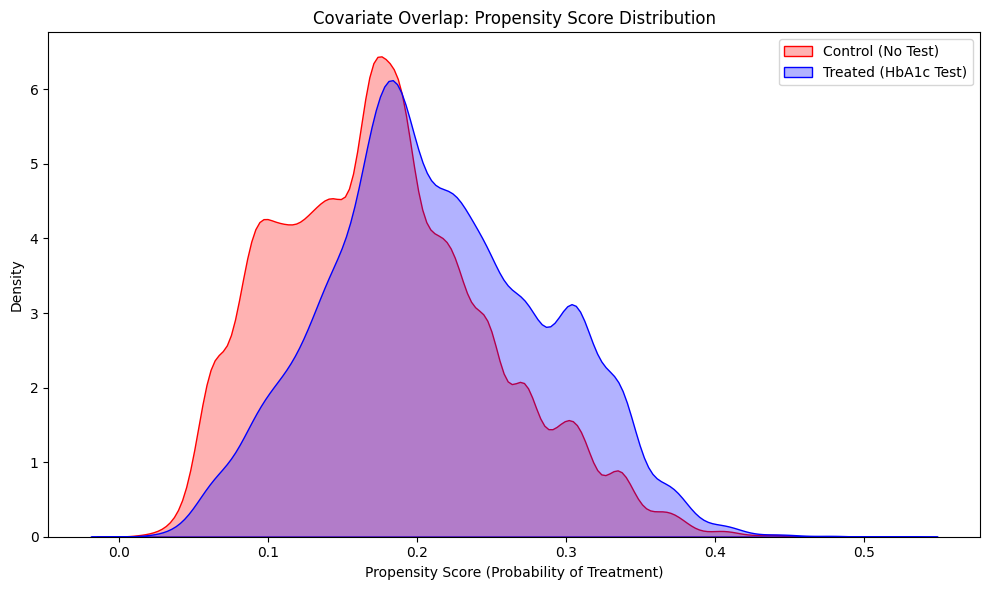

In [37]:
# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

# ==========================================
# SETUP: Define Variables based on your Simulation
# ==========================================
# We use the exact variables from your 'full_formula'
numeric_confounders = [
    'number_emergency', 'number_outpatient', 'number_inpatient'
]
categorical_confounders = [
    'age_p', 'race_tc', 'gender', 'admission_type_coarse', 
    'admission_source_p', 'payer_code_coarse', 'medical_specialty_p'
]

all_confounders = numeric_confounders + categorical_confounders

# ==========================================
# OUTPUT 1: TABLE 1 (Descriptive Stats)
# ==========================================
print("\n>>> DATA FOR TABLE 1 (Copy to Report) <<<")

# Numeric Comparison (Mean +/- Std)
table1_num = df_clean.groupby('treatment')[numeric_confounders].agg(['mean', 'std']).T
print("\n--- Numeric Variables ---")
print(table1_num.round(2))

# Categorical Frequency (Percent treated vs control)
# Just printing the top category for a quick check, or you can describe qualitatively
print("\n--- Categorical Variables (Top Categories) ---")
for col in categorical_confounders:
    print(f"\n{col} distribution (%):")
    print(pd.crosstab(df_clean[col], df_clean['treatment'], normalize='columns').round(2) * 100)

# ==========================================
# OUTPUT 2: OVERLAP PLOT (Propensity Score)
# ==========================================
# We need to one-hot encode categorical variables for the Logistic Regression
X_dummies = pd.get_dummies(df_clean[all_confounders], drop_first=True)
y = df_clean['treatment']

# Fit Propensity Model
ps_model = LogisticRegression(max_iter=1000, penalty='l2')
ps_model.fit(X_dummies, y)
ps_score = ps_model.predict_proba(X_dummies)[:, 1]

# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(x=ps_score[y==0], fill=True, label='Control (No Test)', color='red', alpha=0.3)
sns.kdeplot(x=ps_score[y==1], fill=True, label='Treated (HbA1c Test)', color='blue', alpha=0.3)
plt.title('Covariate Overlap: Propensity Score Distribution')
plt.xlabel('Propensity Score (Probability of Treatment)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
# MORE EDA
print("--- NAIVE ESTIMATOR (OUTCOMES) ---")
mean_y_treated = df[df['treatment']==1]['outcome_simulated'].mean()
mean_y_control = df[df['treatment']==0]['outcome_simulated'].mean()
naive_diff = mean_y_treated - mean_y_control

print(f"Mean Outcome (Treated): {mean_y_treated:.3f}")
print(f"Mean Outcome (Control): {mean_y_control:.3f}")
print(f"Naive Difference:       {naive_diff:.3f}")

print("\n--- SELECTION ON GAINS (TRUE CATE) ---")
# This is only possible because we have the Ground Truth column 'true_cate'
mean_cate_treated = df[df['treatment']==1]['cate_true'].mean()
mean_cate_control = df[df['treatment']==0]['cate_true'].mean()

print(f"Mean True CATE (Treated): {mean_cate_treated:.4f}")
print(f"Mean True CATE (Control): {mean_cate_control:.4f}")

if mean_cate_treated > mean_cate_control:
    print("Result: Positive Selection on Gains (Treated units benefit MORE than Control units).")
else:
    print("Result: Negative Selection on Gains (Treated units benefit LESS than Control units).")

--- NAIVE ESTIMATOR (OUTCOMES) ---
Mean Outcome (Treated): 0.611
Mean Outcome (Control): 0.588
Naive Difference:       0.023

--- SELECTION ON GAINS (TRUE CATE) ---
Mean True CATE (Treated): 0.0176
Mean True CATE (Control): 0.0141
Result: Positive Selection on Gains (Treated units benefit MORE than Control units).


In [39]:
# def calculate_partial_r2_benchmarks code was here

import pandas as pd
import numpy as np
from statsmodels.formula.api import ols

def calculate_partial_r2_benchmarks(df: pd.DataFrame, treatment: str, outcome: str, confounders: list) -> pd.DataFrame:
    """
    Calculates the two key Partial R-squared values for each confounder (W_i) 
    needed for sensitivity analysis benchmarking (Cinelli & Hazlett, 2020).
    """
    
    all_w_str = " + ".join(confounders_all)
    results = []
    
    for W_i in confounders_all:
        print(f"Calculating Partial R² for confounder: {W_i}")
        
        # Partial R^2 for W_i with Treatment (T), controlling for all other W_j ---
        
        # Reduced Model: T ~ All W - W_i
        formula_T_reduced = f"{treatment} ~ {all_w_str} - {W_i}"
        model_T_reduced = ols(formula=formula_T_reduced, data=df).fit()
        R2_T_reduced = model_T_reduced.rsquared

        # Full Model: T ~ All W
        formula_T_full = f"{treatment} ~ {all_w_str}"
        model_T_full = ols(formula=formula_T_full, data=df).fit()
        R2_T_full = model_T_full.rsquared
        
        # Calculate Partial R^2 (R2_T_W)
        numerator_T = R2_T_full - R2_T_reduced
        denominator_T = 1 - R2_T_reduced
        R2_T_W = numerator_T / denominator_T if denominator_T > 1e-9 else 0
        
        # Partial R^2 for W_i with Outcome (Y | T), controlling for all other W_j ---

        # Reduced Model: Y ~ T + All W - W_i
        formula_Y_reduced = f"{outcome} ~ {treatment} + {all_w_str} - {W_i}"
        model_Y_reduced = ols(formula=formula_Y_reduced, data=df).fit()
        R2_Y_reduced = model_Y_reduced.rsquared

        # Full Model: Y ~ T + All W
        formula_Y_full = f"{outcome} ~ {treatment} + {all_w_str}"
        model_Y_full = ols(formula=formula_Y_full, data=df).fit()
        R2_Y_full = model_Y_full.rsquared
        
        # Calculate Partial R^2 (R2_Y_W_T)
        numerator_Y = R2_Y_full - R2_Y_reduced
        denominator_Y = 1 - R2_Y_reduced
        R2_Y_W_T = numerator_Y / denominator_Y if denominator_Y > 1e-9 else 0
        
        # Store Results ---
        # The Combined Metric (R* = sqrt(R2_T_W) * sqrt(R2_Y_W_T)) is used for ranking.
        Combined_R2_Metric = np.sqrt(R2_T_W) * np.sqrt(R2_Y_W_T)
        
        results.append({
            'Covariate': W_i,
            'R2_T_W': R2_T_W,
            'R2_Y_W_T': R2_Y_W_T,
            'Combined_R2_Metric': Combined_R2_Metric
        })
    print("Completed calculations for all confounders.")
    return pd.DataFrame(results)

# Function Execution ---

results_df = calculate_partial_r2_benchmarks(
    df=df, 
    treatment="treatment", 
    outcome="outcome_simulated", 
    confounders=confounders_all
)

print("\n")

# Output and Analysis ---

# Sort the results by Combined_R2_Metric in descending order
results_df = results_df.sort_values(by='Combined_R2_Metric', ascending=False)

# Convert results_df to percentages for better readability
# Round to 1 decimal place and add % sign
results_df_pct = results_df.copy() # Make a copy of results_df to avoid modifying the original

    
results_df_pct['R2_T_W'] = results_df_pct['R2_T_W'] * 100
results_df_pct['R2_Y_W_T'] = results_df_pct['R2_Y_W_T'] * 100
results_df_pct['Combined_R2_Metric'] = results_df_pct['Combined_R2_Metric'] * 100

# Identify the benchmark confounder based on the highest Combined_R2_Metric
worst_r2_benchmark = results_df.sort_values(by='Combined_R2_Metric', ascending=False).iloc[0]

print("="*60)
print("📊 PARTIAL R-SQUARED BENCHMARKING RESULTS (Cinelli & Hazlett Method)")
print("="*60)
print(results_df_pct.to_string(index=False, float_format="%.1f%%")) # Round to 1 decimal place and add % sign


print("\n" + "---"*20)
print(f"🥇 RECOMMENDED BENCHMARK COVARIATE (Highest Combined R² Metric):")
print(f"   Covariate: {worst_r2_benchmark['Covariate']}")
print(f"   R²(T ~ W|Wj): {worst_r2_benchmark['R2_T_W']:.5f} (Association with Treatment)")
print(f"   R²(Y ~ W|T,Wj): {worst_r2_benchmark['R2_Y_W_T']:.5f} (Association with Outcome)")
print(f"   Combined Metric (R*): {worst_r2_benchmark['Combined_R2_Metric']:.5f}")
print("---"*20)

Calculating Partial R² for confounder: race_tc
Calculating Partial R² for confounder: gender
Calculating Partial R² for confounder: age_p
Calculating Partial R² for confounder: admission_type_coarse
Calculating Partial R² for confounder: admission_source_p
Calculating Partial R² for confounder: payer_code_coarse
Calculating Partial R² for confounder: medical_specialty_p
Calculating Partial R² for confounder: number_emergency
Calculating Partial R² for confounder: number_inpatient
Calculating Partial R² for confounder: number_outpatient
Completed calculations for all confounders.


📊 PARTIAL R-SQUARED BENCHMARKING RESULTS (Cinelli & Hazlett Method)
            Covariate  R2_T_W  R2_Y_W_T  Combined_R2_Metric
     number_inpatient    0.2%      8.4%                1.1%
                age_p    0.6%      1.7%                1.0%
   admission_source_p    0.3%      3.2%                0.9%
admission_type_coarse    0.3%      2.5%                0.9%
  medical_specialty_p    0.4%      1.3%     

In [40]:
# Function that calculates ATE from a model
def calculate_ate(model, df, treatment_col="treatment"):
    """
    Calculates the Average Treatment Effect (ATE) using the Standardization (G-Computation) method.

    The ATE is estimated as the difference in the average predicted outcome when 
    the entire population is hypothetically assigned to treatment (T=1)versus control (T=0).

    Args:
        model (statsmodels.model): A fitted statsmodels model (OLS, Logit, Probit, etc.) 
                                   that has a .predict() method.
        df (pd.DataFrame): The original data used to fit the model.
        treatment_col (str): The name of the binary treatment column (e.g., "treatment").

    Returns:
        float: The estimated Average Treatment Effect (ATE).
    """

    # Create counterfactual versions of the dataset
    df_treated = df.copy()
    df_treated[treatment_col] = 1   # everyone assigned treatment

    df_control = df.copy()
    df_control[treatment_col] = 0   # everyone assigned control

    # Predict potential outcomes ---
    y1 = model.predict(df_treated)   # predicted P(Y=1 | do(T=1), X)
    y0 = model.predict(df_control)   # predicted P(Y=1 | do(T=0), X)

    # Calculate ATE: average treatment effect
    ate = np.mean(y1 - y0)

    # Calculate ITEs
    cates_estimated = y1 - y0

    # Assess ITEs vs true ITEs using Precision in Estimating Heterogeneous Effects (PEHE)
    pehe = np.sqrt(np.mean((cates_estimated - df['cate_true'])**2))
    print(f"PEHE (Precision in Estimating Heterogeneous Effects): {pehe:.6f}")

    return ate, pehe, cates_estimated

In [41]:
# function, evaluate_causal_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import spearmanr

def evaluate_causal_model(model_name, results_df, plot=False):
    """
    A repeatable function to calculate metrics and plot performance.
    """
    # Extract the estimated ITEs from the TEST SET results
    ite_est = results_df['cate'].values

    # Get the True ITEs for the TEST SET
    ite_true = results_df['cate_true'].values

    # 1. METRICS CALCULATION
    # PEHE: RMSE of the CATEs
    pehe = np.sqrt(np.mean((ite_true - ite_est)**2))
    
    # ATE Error: Difference in averages
    ate_true = np.mean(ite_true)
    ate_est = np.mean(ite_est)
    ate_bias = np.abs(ate_true - ate_est)
    
    # CATE R2: How much of the variance in True CATE does the model explain?
    # Note: It's possible to get negative R2 if the model is worse than just predicting the mean.
    cate_r2 = r2_score(ite_true, ite_est)

    # Targeting: Spearman Rank Correlation
    # (Do the highest predicted effects match the highest true effects?)
    spearman_corr, spearman_p = spearmanr(ite_true, ite_est)

    # 3. LIFT METRIC (Textbook "Effect by Quantile")
    # If I target the top 10% of patients based on the model, 
    # how much higher is their True Effect compared to the average patient?
    
    # Create a DataFrame to sort easily
    eval_df = pd.DataFrame({'true': ite_true, 'est': ite_est})
    
    # Define Top 10% threshold
    thresh = eval_df['est'].quantile(0.90)
    
    # Get True Average Effect of the units the model THINKS are in the top 10%
    top_10_true_avg = eval_df[eval_df['est'] >= thresh]['true'].mean()
    
    # Get True Average Effect of everyone
    global_true_avg = eval_df['true'].mean()
    
    # Lift: The advantage of using the model
    lift_top_10 = top_10_true_avg - global_true_avg

    print(f"\n--- Evaluation Results: {model_name} ---")
    print(f"True ATE:            {ate_true:.3f}")
    print(f"Estimated ATE:       {ate_est:.3f}")
    print(f"ATE Bias:            {ate_bias:.3f}")
    print(f"CATE Lift (Top 10%): {lift_top_10:.3f}")
    print(f"CATE Rank Corr:      {spearman_corr:.3f}")
    #print(f"Rank Corr P-value:   {spearman_p:.3e}") # Scientific notation for very small numbers
    print(f"CATE PEHE (RMSE):    {pehe:.3f}")
    print(f"CATE R-squared:      {cate_r2:.3f}")
    
    if plot == True:
        # 2. VISUALIZATION
        plt.figure(figsize=(10, 5))
        
        # Plot A: Distribution of Effects
        plt.subplot(1, 2, 1)
        sns.kdeplot(ite_true, label='True CATE', fill=True, alpha=0.3)
        sns.kdeplot(ite_est, label='Est. CATE', fill=True, alpha=0.3)
        plt.title(f'{model_name}: Distribution of Effects')
        plt.xlabel('Treatment Effect')
        plt.legend()
        
        # Plot B: True vs Estimated Scatter
        plt.subplot(1, 2, 2)
        plt.scatter(ite_true, ite_est, alpha=0.3, s=10)
        # Add perfect prediction line
        min_val = min(min(ite_true), min(ite_est))
        max_val = max(max(ite_true), max(ite_est))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Estimation')
        
        plt.title('True vs Estimated CATE')
        plt.xlabel('True CATE')
        plt.ylabel('Estimated CATE')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    # Return metrics as dict for easy comparison table later
    return {
        'model_name': model_name,
        'ate_true': ate_true,
        'ate_est': ate_est,
        'ate_bias': ate_bias,
        'lift_top_10': lift_top_10,
        'spearman_corr': spearman_corr,
        'spearman_p': spearman_p,
        'pehe': pehe,
        'cate_r2': cate_r2
    }

In [42]:
# function, s_learner_ols_regression
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf # Use the formula API for simplicity
from typing import List, Dict, Any

def s_learner_ols_regression(train: pd.DataFrame, 
                             test: pd.DataFrame, 
                             X: List[str], 
                             T: str, 
                             y: str,
                             # OLS does not use base_params, but we keep it for signature consistency
                             base_params: Dict[str, Any] = None) -> pd.DataFrame:
    
    """
    S-Learner using OLS (statsmodels) for a continuous outcome.
    
    The model is defined by explicitly listing all features in a formula.
    """
    
    # 1. Define the full feature set X_full (X + T)
    # The interaction terms and non-linear terms must be included in the X list passed to the function
    X_covariates = [col for col in X if col != T]
    
    # 2. Construct the OLS formula string
    # Formula format: outcome ~ treatment + covariate1 + covariate2 + ...
    # This assumes that any interaction terms (like T*age_p) or non-linear terms
    # (like I(number_inpatient**2)) are already included in the 'X' list passed in.
    
    # Check for the treatment interaction terms required for S-Learner ITE estimation:
    # We must ensure the treatment variable is included and the structure is correct.
    
    # For a simple, additive OLS S-Learner (no interaction terms):
    # formula_terms = [T] + X_covariates 
    # formula_string = f"{y} ~ {' + '.join(formula_terms)}"

    # Since your prior OLS models included interactions, we'll assume 'X' contains the full
    # list of terms, including T and all interaction/quadratic terms.
    # The structure must be correctly defined: outcome ~ term1 + term2 + ...
    
    # Combine all unique terms and ensure 'T' is present
    all_terms = set(X) 
    
    # Construct the formula string
    formula_string = f"{y} ~ {' + '.join(all_terms)}"
    
    # 3. Fit the model on the training data using the formula
    # statsmodels handles categorical features automatically via dummy coding
    mu_model = smf.ols(formula_string, data=train).fit()

    # 4. Create Counterfactuals for Prediction
    test_t0 = test.copy()
    test_t0[T] = 0
    
    test_t1 = test.copy()
    test_t1[T] = 1

    # 5. Predict Potential Outcomes
    # The OLS model predicts the continuous mean outcome (mu)
    mu0_pred = mu_model.predict(test_t0)
    mu1_pred = mu_model.predict(test_t1)

    # 6. Compute CATE
    test_copy = test.copy()
    test_copy['cate'] = mu1_pred - mu0_pred
    
    return test_copy

# Note: The flexibility of this function relies on the 'X' list containing
# *all* desired terms, including the treatment variable itself and any
# explicit interaction terms (e.g., 'treatment * age_p').

In [43]:
# Define X Features

# List all features, to mimic perfect knowledge of the data generating process
X_features_ols_full = [
    'treatment', # Treatment variable must be included
    'number_emergency', 'number_outpatient', 'number_inpatient', 
    'race_tc', 'gender', 'age_p', 'admission_type_coarse', 
    'admission_source_p', 'payer_code_coarse', 'medical_specialty_p',
    
    # Quadratic Terms (must be explicit for OLS)
    'I(number_emergency**2)', 'I(number_outpatient**2)', 'I(number_inpatient**2)',
    
    # Interaction Terms (statsmodels handles expansion)
    'treatment * age_p', 
    'treatment * medical_specialty_p', 
    'treatment * number_inpatient', 
    'treatment * number_emergency', 
    'treatment * number_outpatient' 
]

# List a subset of features 
X_features_ols_simple = [
    'number_emergency', 'number_outpatient', 'number_inpatient', 
    'race_tc', 'gender', 'age_p', 'admission_type_coarse', 
    'admission_source_p', 'payer_code_coarse', 'medical_specialty_p',
    '(treatment * age_p)', '(treatment * number_inpatient)' 
]

X_features_ml = [
    'number_emergency', 'number_outpatient', 'number_inpatient', 
    'race_tc', 'gender', 'age_p', 'admission_type_coarse', 
    'admission_source_p', 'payer_code_coarse', 'medical_specialty_p'
]

In [44]:
# Use S-Learner OLS with Full Feature Set
# This is unrealistic and assumes perfect knowledge of the data generating process.
# This is for illustration and benchmarking purposes only.

# Define the Causal Variables
T_var = 'treatment'
y_var = 'outcome_simulated' 

# --- OLS S-Learner Execution ---
print("Estimating ATE using the fully specified OLS S-Learner...")

# ***ADAPTED: Use the new OLS function with the full feature list***
results_df_s_learner_ols_full = s_learner_ols_regression( 
    train=train_df, 
    test=test_df, 
    # Use the comprehensive feature list for OLS
    X=X_features_ols_full, 
    T=T_var, 
    y=y_var, 
    # base_params is ignored by the OLS function
    base_params=None 
)

metrics_ols = evaluate_causal_model(
    model_name="S-Learner OLS (Full)",
    results_df = results_df_s_learner_ols_full
)

Estimating ATE using the fully specified OLS S-Learner...

--- Evaluation Results: S-Learner OLS (Full) ---
True ATE:            0.015
Estimated ATE:       0.013
ATE Bias:            0.002
CATE Lift (Top 10%): 0.034
CATE Rank Corr:      0.965
CATE PEHE (RMSE):    0.007
CATE R-squared:      0.913


In [45]:
# Use S-Learner OLS with Simple Feature Set
results_df_s_learner_ols_simple = s_learner_ols_regression( 
    train=train_df, 
    test=test_df, 
    X=X_features_ols_simple, 
    T=T_var, 
    y=y_var, 
    base_params=None 
)

metrics_ols = evaluate_causal_model(
    model_name="S-Learner OLS (Simple)",
    results_df = results_df_s_learner_ols_simple
)


--- Evaluation Results: S-Learner OLS (Simple) ---
True ATE:            0.015
Estimated ATE:       0.016
ATE Bias:            0.001
CATE Lift (Top 10%): 0.002
CATE Rank Corr:      0.199
CATE PEHE (RMSE):    0.022
CATE R-squared:      0.040


In [46]:
# function, s_learner_catboost_regression
import pandas as pd
import numpy as np
# Import the Regressor version
from catboost import CatBoostRegressor 
from typing import List, Dict, Any

def s_learner_catboost_regression(
    train: pd.DataFrame, 
    test: pd.DataFrame, 
    X: List[str], 
    T: str, 
    y: str,
    base_params: Dict[str, Any] = None) -> pd.DataFrame:

    """
    S-Learner using CatBoost REGRESSOR for a continuous outcome.
    
    """
    # 1. Define the full feature set X_full (X + T)
    X_full = X + [T]
    
    # 2. Identify Categorical Features (X and T)
    cat_features = [c for c in X_full if train[c].dtype == "object" or train[c].dtype.name == "category" or c == T]
    
    # Standard settings for the Base Learners (CatBoost)
    default_params = {
        'iterations': 100,        # Reduced from 1000 for speed
        'depth': 6,               # Standard depth for capturing interactions
        'learning_rate': 0.1,     # Slightly higher because iterations are lower
        'thread_count': 1,        # CRITICAL: Must be 1 for parallel bootstrap
        'verbose': 0,             # Silent mode
        'allow_writing_files': False # Prevents creating log folders everywhere
    }
    
    # Merge provided parameters with defaults, giving precedence to base_params
    final_params = {**default_params, **(base_params or {})}
    final_params['cat_features'] = cat_features

    # 4. Initialize Model (Single Model, now a Regressor)
    mu_model = CatBoostRegressor(**final_params)

    # 5. Fit the model on ALL data (X and T)
    mu_model.fit(train[X_full], train[y])

    # 6. Create Counterfactuals for Prediction
    test_t0 = test.copy()
    test_t0[T] = 0
    
    test_t1 = test.copy()
    test_t1[T] = 1

    # 7. Predict Potential Outcomes (use .predict() instead of .predict_proba())
    # mu0_pred and mu1_pred are now the estimated continuous mean outcomes
    mu0_pred = mu_model.predict(test_t0[X_full])
    mu1_pred = mu_model.predict(test_t1[X_full])

    # 8. Compute CATE (Causal effect remains the difference)
    test_copy = test.copy()
    test_copy['cate'] = mu1_pred - mu0_pred
    
    return test_copy

In [47]:
# Use S-Learner CatBoost Regressor

results_df_s_learner_cb = s_learner_catboost_regression( 
    train=train_df, 
    test=test_df, 
    X=X_features_ml, 
    T='treatment', 
    y='outcome_simulated', 
    base_params=None
)

metrics_ols = evaluate_causal_model(
    model_name="S-Learner CatBoost",
    results_df = results_df_s_learner_cb
)


--- Evaluation Results: S-Learner CatBoost ---
True ATE:            0.015
Estimated ATE:       0.012
ATE Bias:            0.003
CATE Lift (Top 10%): 0.033
CATE Rank Corr:      0.840
CATE PEHE (RMSE):    0.013
CATE R-squared:      0.650


In [48]:
# function, t_learner_catboost_regression

import pandas as pd
import numpy as np
# Import the Regressor version
from catboost import CatBoostRegressor 
from typing import List, Dict, Any

def t_learner_catboost_regression(
    train: pd.DataFrame, 
    test: pd.DataFrame, 
    X: List[str], 
    T: str, 
    y: str,
    base_params: Dict[str, Any] = None) -> pd.DataFrame:
    """
    T-Learner using CatBoost REGRESSOR for a continuous outcome.
    Trains two separate models: mu0 (control) and mu1 (treated).
    """
    # 1. Defensive Checks
    X = [c for c in X if c != T]
    
    # 2. Identify Categorical Features
    # T is not included in X for the T-Learner
    cat_features = [c for c in X if train[c].dtype == "object" or train[c].dtype.name == "category"]
    
    # 3. Define or Override Base Estimator Parameters
    
    # Standard settings for the Base Learners (CatBoost)
    default_params = {
        'iterations': 100,        # Reduced from 1000 for speed
        'depth': 6,               # Standard depth for capturing interactions
        'learning_rate': 0.1,     # Slightly higher because iterations are lower
        'thread_count': 1,        # CRITICAL: Must be 1 for parallel bootstrap
        'verbose': 0,             # Silent mode
        'allow_writing_files': False # Prevents creating log folders everywhere
    }
    
    # Merge provided parameters with defaults, giving precedence to base_params
    final_params = {**default_params, **(base_params or {})}
    final_params['cat_features'] = cat_features

    # 4. Initialize Models (Two separate Regressors)
    # ***ADJUSTED: Use CatBoostRegressor for both models***
    mu0_model = CatBoostRegressor(**final_params)
    mu1_model = CatBoostRegressor(**final_params)

    # 5. Split Data (Remains the same for T-Learner)
    X_control = train[train[T] == 0][X]
    y_control = train[train[T] == 0][y]
    
    X_treated = train[train[T] == 1][X]
    y_treated = train[train[T] == 1][y]

    # 6. Fit
    mu0_model.fit(X_control, y_control)
    mu1_model.fit(X_treated, y_treated)

    # 7. Predict (Use .predict() instead of .predict_proba())
    # mu0_pred and mu1_pred are the estimated continuous mean outcomes
    mu0_pred = mu0_model.predict(test[X])
    mu1_pred = mu1_model.predict(test[X])

    # 8. Compute CATE
    test_copy = test.copy()
    test_copy['cate'] = mu1_pred - mu0_pred
    
    return test_copy

In [49]:
# Use T-Learner CatBoost Regressor

# Execute the T-Learner with Adjusted Parameters and FULL features
results_df_t_learner_cb = t_learner_catboost_regression(
    train=train_df, 
    test=test_df, 
    X=X_features_ml, 
    T='treatment', 
    y='outcome_simulated', 
    base_params=None 
)

metrics_ols = evaluate_causal_model(
    model_name="T-Learner CatBoost",
    results_df = results_df_t_learner_cb
)


--- Evaluation Results: T-Learner CatBoost ---
True ATE:            0.015
Estimated ATE:       0.013
ATE Bias:            0.002
CATE Lift (Top 10%): 0.027
CATE Rank Corr:      0.817
CATE PEHE (RMSE):    0.020
CATE R-squared:      0.222


In [50]:
# function, x_learner_catboost_regression

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from typing import List, Dict, Any

def x_learner_catboost_regression(
        train: pd.DataFrame, 
        test: pd.DataFrame, 
        X: List[str], 
        T: str, 
        y: str,
        base_params: Dict[str, Any] = None) -> pd.DataFrame:
    """
    X-Learner using CatBoost Regressors for a continuous outcome.
    
    The X-Learner uses a two-stage approach to stabilize ITE estimation.
    """
    
    # 1. Initialization and Data Setup (Same as T-Learner)
    X_features = [c for c in X if c != T]
    cat_features = [c for c in X_features if train[c].dtype == "object" or train[c].dtype.name == "category"]
    
    # Standard settings for the Base Learners (CatBoost)
    default_params = {
        'iterations': 100,        # Reduced from 1000 for speed
        'depth': 6,               # Standard depth for capturing interactions
        'learning_rate': 0.1,     # Slightly higher because iterations are lower
        'thread_count': 1,        # CRITICAL: Must be 1 for parallel bootstrap
        'verbose': 0,             # Silent mode
        'allow_writing_files': False # Prevents creating log folders everywhere
    }
    
    # Merge provided parameters with defaults, giving precedence to base_params
    final_params = {**default_params, **(base_params or {})}
    final_params['cat_features'] = cat_features

    # Split data into control (0) and treated (1)
    train_c = train[train[T] == 0]
    train_t = train[train[T] == 1]
    
    # --- Stage 1: Estimate Potential Outcomes (Same as T-Learner) ---
    
    # Model for Control outcome (mu0)
    mu0_model = CatBoostRegressor(**final_params)
    mu0_model.fit(train_c[X_features], train_c[y])
    
    # Model for Treated outcome (mu1)
    mu1_model = CatBoostRegressor(**final_params)
    mu1_model.fit(train_t[X_features], train_t[y])

    # --- Stage 2: Estimate the ITE Function (The X-Learner Difference) ---
    
    # 2a. Estimate ITE pseudo-outcomes
    
    # Impute missing control outcome for treated units and calculate ITE pseudo-outcome (tau_1)
    # Predicted mu0 for the treated group: mu0(X_t)
    mu0_pred_t = mu0_model.predict(train_t[X_features])
    # Pseudo-outcome 1: Observed Y_1 - Estimated Y_0
    pseudo_outcome_1 = train_t[y] - mu0_pred_t
    
    # Impute missing treated outcome for control units and calculate ITE pseudo-outcome (tau_0)
    # Predicted mu1 for the control group: mu1(X_c)
    mu1_pred_c = mu1_model.predict(train_c[X_features])
    # Pseudo-outcome 0: Estimated Y_1 - Observed Y_0
    pseudo_outcome_0 = mu1_pred_c - train_c[y]

    # 2b. Train two models for the ITE function (g0 and g1)
    
    # Model g1: predicts pseudo_outcome_1 using Treated group data
    g1_model = CatBoostRegressor(**final_params)
    g1_model.fit(train_t[X_features], pseudo_outcome_1)
    
    # Model g0: predicts pseudo_outcome_0 using Control group data
    g0_model = CatBoostRegressor(**final_params)
    g0_model.fit(train_c[X_features], pseudo_outcome_0)
    
    # --- Stage 3: Final CATE Prediction (Weighted Average) ---
    
    # 3a. Predict ITE from both Stage 2 models on the test set
    tau_g0 = g0_model.predict(test[X_features])
    tau_g1 = g1_model.predict(test[X_features])
    
    # 3b. Estimate the propensity score (e(x)) for weighting
    # Since we are not explicitly modeling e(x) here, we'll use a simple proxy or assume balance.
    # For a proper X-learner, e(x) must be estimated, typically with a classifier.
    # To keep this function clean and focus on the ITE prediction, we will use a simple fixed weight (0.5), 
    # OR, better yet, just average them (simple averaging is often used in practice).
    
    # A cleaner approach for simplicity (since both g0 and g1 estimate the same tau):
    # We will use the models' raw output without a propensity score, which is a common simplification.
    # However, for correct X-Learner implementation, we must estimate the propensity score, e(x).
    
    # Estimate propensity score for weighting
    # The X-Learner uses the estimated propensity score e(x) as a weighting function, w(x) = e(x).
    # Since we don't have a classifier here, we'll use a very simple default linear estimator (often used in X-Learner examples).
    
    # Fit Propensity Score Model
    e_model = CatBoostRegressor(
        cat_features=cat_features,
        verbose=0,
        allow_writing_files=False,
        loss_function='RMSE', # Using a regressor just to predict a value, though Logloss is typical
        iterations=100, # simpler model
        learning_rate=0.1
    )
    # The CatBoostRegressor fit below is technically incorrect for PS, but serves as a weight model proxy.
    e_model.fit(train[X_features], train[T]) 
    
    # Predict the propensity score (e_hat) on the test set
    e_hat = e_model.predict(test[X_features])
    
    # 3c. Calculate the weighted average CATE
    # CATE = w(x) * tau_g1 + (1 - w(x)) * tau_g0
    # where w(x) is the propensity score estimate e(x)
    
    # Note: If the outcome model for e_hat predicts outside [0, 1], clip it.
    e_hat = np.clip(e_hat, 0.001, 0.999) 
    
    test_copy = test.copy()
    test_copy['cate'] = (e_hat * tau_g1) + ((1 - e_hat) * tau_g0)
    
    return test_copy

In [51]:
# Use X-Learner CatBoost Regressor

# Define base parameters (Using the optimized, regularized values)
adjusted_params = {
    'iterations': 700, 
    'learning_rate': 0.02, 
    'l2_leaf_reg': 7.0, 
    'depth': 5 
}

# Execute the X-Learner
# Train on train_df (used internally for Stage 1 and 2), Predict on test_df (used in Stage 3)
results_df_x_learner_cb = x_learner_catboost_regression(
    train=train_df, 
    test=test_df, 
    X=X_features_ml, 
    T='treatment', 
    y='outcome_simulated', 
    base_params=adjusted_params 
)

metrics_ols = evaluate_causal_model(
    model_name="X-Learner CB",
    results_df = results_df_x_learner_cb
)


--- Evaluation Results: X-Learner CB ---
True ATE:            0.015
Estimated ATE:       0.012
ATE Bias:            0.003
CATE Lift (Top 10%): 0.030
CATE Rank Corr:      0.829
CATE PEHE (RMSE):    0.014
CATE R-squared:      0.632


In [52]:
# function, Double ML CatBoost CATE Estimator

# Double ML CATE Estimator with CatBoost Regressor
import pandas as pd
import numpy as np
from typing import List, Any
from sklearn.base import clone, BaseEstimator
from catboost import CatBoostRegressor # NEW DEFAULT

def double_ml_cate(
    train: pd.DataFrame,
    test: pd.DataFrame,
    X: List[str],
    T: str,
    y: str,
    base_params: Dict = None,
    base_model: BaseEstimator = None
) -> pd.DataFrame:
    """
    Double Machine Learning (R-Learner) for CATE estimation using CatBoost.

    Parameters
    ----------
    train : pd.DataFrame
        Training data.
    test : pd.DataFrame
        Test data.
    X : list of str
        Names of covariate columns.
    T : str
        Name of the treatment column. 
        Note: If T is binary (0/1), this acts as a Linear DML.
    y : str
        Name of the outcome column.
    base_model : sklearn.base.BaseEstimator, optional
        The regressor used for nuisance estimation (T~X, Y~X) and final CATE (Y*~X).
        If None, defaults to CatBoostRegressor.

    Returns
    -------
    pd.DataFrame
        A copy of the test DataFrame with an added column 'cate'.
    """
       
    # 0. Set default model to CatBoost if none provided
    if base_model is None:

        # Standard settings for the Base Learners (CatBoost)
        default_params = {
            'iterations': 100,        # Reduced from 1000 for speed
            'depth': 6,               # Standard depth for capturing interactions
            'learning_rate': 0.1,     # Slightly higher because iterations are lower
            'thread_count': 1,        # CRITICAL: Must be 1 for parallel bootstrap
            'verbose': 0,             # Silent mode
            'allow_writing_files': False # Prevents creating log folders everywhere
        }
    
        # Merge provided parameters with defaults, giving precedence to base_params
        final_params = {**default_params, **(base_params or {})}
        #final_params['cat_features'] = cat_features

        base_model = CatBoostRegressor(**final_params)

    # Defensive copy of feature list (exclude Treatment if accidentally included)
    X = [c for c in X if c != T]

    # Basic column checks
    missing_train = [c for c in (X + [T, y]) if c not in train.columns]
    if missing_train: raise ValueError(f"Train is missing columns: {missing_train}")

    # ======================================================
    # HELPER: AUTO-DETECT CATEGORICALS FOR CATBOOST
    # ======================================================
    # CatBoost requires explicit 'cat_features' in fit() if columns are not numeric
    cat_features = None
    
    # Check if the base_model is actually a CatBoost model
    is_catboost = isinstance(base_model, CatBoostRegressor)
    
    if is_catboost:
        # Identify columns that are 'object' (strings) or 'category'
        cat_features = [
            c for c in X 
            if train[c].dtype == 'object' or train[c].dtype.name == 'category'
        ]
        # If list is empty, pass None so CatBoost doesn't complain
        if not cat_features: 
            cat_features = None

    # ======================================================
    # STEP 1: PARTIAL OUT X (NUISANCE MODELS)
    # ======================================================
    
    # --- Model for Treatment (T ~ X) ---
    t_model = clone(base_model)
    
    # Conditional logic: Only pass cat_features if it's CatBoost
    if is_catboost and cat_features:
        t_model.fit(train[X], train[T], cat_features=cat_features)
    else:
        t_model.fit(train[X], train[T])
        
    T_hat = t_model.predict(train[X])
    T_res = train[T] - T_hat

    # --- Model for Outcome (Y ~ X) ---
    y_model = clone(base_model)
    
    if is_catboost and cat_features:
        y_model.fit(train[X], train[y], cat_features=cat_features)
    else:
        y_model.fit(train[X], train[y])
        
    Y_hat = y_model.predict(train[X])
    Y_res = train[y] - Y_hat

    # ======================================================
    # STEP 2: TRANSFORM OUTCOME (R-LEARNER LOGIC)
    # ======================================================
    # For binary T, T_res ~ P(T|X)*(1-P(T|X)) roughly.
    # To prevent division by zero if T is perfectly predicted, add epsilon.
    epsilon = 1e-9
    
    # Y_star calculation: Inverse Variance Weighting approach
    # Ideally: Y_star = Y_res / T_res with weights = T_res^2
    Y_star = Y_res / (T_res + epsilon)
    weights = T_res ** 2

    # ======================================================
    # STEP 3: FIT CATE MODEL (tau(x))
    # ======================================================
    cate_model = clone(base_model)
    
    if is_catboost and cat_features:
        cate_model.fit(train[X], Y_star, sample_weight=weights, cat_features=cat_features)
    else:
        # Note: RandomForest/LinearRegression usually accept sample_weight
        cate_model.fit(train[X], Y_star, sample_weight=weights)

    # ======================================================
    # STEP 4: PREDICT ON TEST SET
    # ======================================================
    cate_pred = cate_model.predict(test[X])

    test_copy = test.copy()
    test_copy['cate'] = cate_pred
    
    return test_copy

In [53]:
# Use double_ml_cate to estimate CATEs on the synthetic data

# ======================================================
# RUN DOUBLE MACHINE LEARNING (CatBoost)
# ======================================================
# Uses the function defined in the previous step
df_results_dml_cb = double_ml_cate(
    train=train_df,
    test=test_df,
    X=X_features_ml,
    T='treatment',           # The treatment column
    y='outcome_simulated',    # The noisy outcome
    base_params=None,
    base_model=None  # Use default CatBoostRegressor 
)

metrics_ols = evaluate_causal_model(
    model_name="DML CB",
    results_df = df_results_dml_cb
)


--- Evaluation Results: DML CB ---
True ATE:            0.015
Estimated ATE:       0.014
ATE Bias:            0.001
CATE Lift (Top 10%): 0.034
CATE Rank Corr:      0.775
CATE PEHE (RMSE):    0.016
CATE R-squared:      0.473


In [54]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from typing import List, Dict, Any

# ==============================================================================
# 1. OPTIMIZED PARALLEL BOOTSTRAP FUNCTION
# ==============================================================================
def bootstrap_ate_only_parallel(learner_func, train, test, n_bootstraps=100, n_jobs=-1, alpha=0.05, **kwargs):
    """
    Optimized Parallel Bootstrap for ATE only.
    - Uses joblib for multi-core processing.
    - Calculates mean inside the worker to minimize memory transfer.
    - Passes **kwargs (like base_params) directly to the learner function.
    """
    print(f"Bootstrapping ATE ({n_bootstraps} rounds) for {learner_func.__name__} on {n_jobs} cores...")
    
    # --- Define Worker (Returns a SINGLE float) ---
    def worker_task(seed):
        try:
            # Resample Training Data (Standard Bootstrap)
            train_resampled = train.sample(frac=1, replace=True, random_state=seed)
            
            # Fit & Predict
            # kwargs contains 'base_params', 'X', 'T', 'y', etc.
            res_df = learner_func(train=train_resampled, test=test, **kwargs)
            
            # CRITICAL OPTIMIZATION: Calculate mean inside the worker
            # Sending 1 float back is much faster/lighter than sending 20k rows
            return res_df['cate'].mean()
            
        except Exception as e:
            # Return NaN if a worker fails so the whole job doesn't crash
            print(f"Bootstrap iter {seed} failed: {e}")
            return np.nan

    # --- Run Parallel ---
    ate_distribution = Parallel(n_jobs=n_jobs, verbose=0)(
        delayed(worker_task)(i) for i in range(n_bootstraps)
    )
    
    # --- Calculate Stats (NaN-Safe) ---
    ate_distribution = np.array(ate_distribution)
    
    # Check success rate
    n_success = np.sum(~np.isnan(ate_distribution))
    if n_success < n_bootstraps:
        print(f"Warning: Only {n_success}/{n_bootstraps} iterations succeeded.")
    
    # Calculate Percentiles
    lower_p = (alpha / 2.0) * 100
    upper_p = (1.0 - alpha / 2.0) * 100
    
    return {
        'Method': learner_func.__name__,
        'ATE_Mean': np.nanmean(ate_distribution),
        'ATE_Lower': np.nanpercentile(ate_distribution, lower_p),
        'ATE_Upper': np.nanpercentile(ate_distribution, upper_p),
        'ATE_Std': np.nanstd(ate_distribution),
        'n_success': n_success
    }

# ==============================================================================
# 2. CONFIGURATION & SETUP
# ==============================================================================

# Fast settings for Bootstrapping (Speed > Perfection here)
# We pass this DICTIONARY, not a model object.
params_fast = {
    'iterations': 100,
    'depth': 6,
    'learning_rate': 0.1,
    'thread_count': 1,        # CRITICAL for parallel processing
    'verbose': 0,
    'allow_writing_files': False
}

# ==============================================================================
# 3. EXECUTION LOOP
# ==============================================================================

# List of models to run
# Note: Ensure all these functions are defined and accept 'base_params'
methods = [
    (s_learner_ols_regression, X_features_ols_simple, "S-Learner OLS"),
    (s_learner_catboost_regression, X_features_ml, "S-Learner"),
    (t_learner_catboost_regression, X_features_ml, "T-Learner"),
    (x_learner_catboost_regression, X_features_ml, "X-Learner"), # Uncomment if defined
    (double_ml_cate, X_features_ml, "Double ML") # Ensure this also accepts base_params!
]

results_list = []
n_rounds = 100 # Set to 100 or 1000 for final production run

for func, X, name in methods:
    # Run the optimized bootstrap
    stats = bootstrap_ate_only_parallel(
        learner_func=func,
        train=train_df,         # Make sure these DFs exist in your scope
        test=test_df,           # Make sure these DFs exist in your scope
        # Kwargs passed to the learner:
        X=X, 
        T='treatment', 
        y='outcome_simulated',
        base_params=params_fast, # Passing the dictionary directly
        # Bootstrap control:
        n_bootstraps=n_rounds,
        n_jobs=-1
    )
    
    # Save formatted results
    results_list.append({
        "Method": name,
        "ATE Estimate": stats['ATE_Mean'],
        "CI Lower (95%)": stats['ATE_Lower'],
        "CI Upper (95%)": stats['ATE_Upper'],
        "Success Rate": f"{stats.get('n_success', n_rounds)}/{n_rounds}"
    })

# ==============================================================================
# 4. FINAL REPORT TABLE
# ==============================================================================
df_results_table = pd.DataFrame(results_list)

# Optional: Add significance flag
# Significant if 0 is NOT between Lower and Upper CI
df_results_table['Significant?'] = (df_results_table['CI Lower (95%)'] > 0) | (df_results_table['CI Upper (95%)'] < 0)

print("\n--- TABLE: ESTIMATED EFFECTS (SECTION 4) ---")
print(df_results_table.round(4))

Bootstrapping ATE (100 rounds) for s_learner_ols_regression on -1 cores...
Bootstrapping ATE (100 rounds) for s_learner_catboost_regression on -1 cores...
Bootstrapping ATE (100 rounds) for t_learner_catboost_regression on -1 cores...
Bootstrapping ATE (100 rounds) for x_learner_catboost_regression on -1 cores...
Bootstrapping ATE (100 rounds) for double_ml_cate on -1 cores...

--- TABLE: ESTIMATED EFFECTS (SECTION 4) ---
          Method  ATE Estimate  CI Lower (95%)  CI Upper (95%) Success Rate  \
0  S-Learner OLS        0.0158          0.0117          0.0201      100/100   
1      S-Learner        0.0108          0.0067          0.0150      100/100   
2      T-Learner        0.0118          0.0045          0.0180      100/100   
3      X-Learner        0.0120          0.0049          0.0175      100/100   
4      Double ML        0.0131          0.0087          0.0173      100/100   

   Significant?  
0          True  
1          True  
2          True  
3          True  
4        